# Predição de ativos da bolsa de valores

# Importa as bibliotecas

In [1]:
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import plot
import plotly.graph_objects as go

import datetime
from pmdarima.arima import auto_arima # biblioteca que importa o arima
import pmdarima.arima as pm # biblioteca que importa o arima
import statsmodels
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import pandas as pd

from pandas_datareader import data 
import yfinance as yfin
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [2]:
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv1D, LSTM, MaxPooling1D, Activation, MaxPooling1D, Dropout, Flatten, BatchNormalization, GRU, AveragePooling1D, SpatialDropout1D, GlobalAveragePooling1D
#from tensorflow.keras.initializers import he_uniform
from tensorflow import keras

## Análise e visualização de ativos

### Carrega Dados

In [3]:
import yfinance as yf
import pandas as pd

yf.pdr_override()

cryptos=['BTC','ETH','SOL','ADA','TRX','FET','INJ']
peso_cryptos=np.ones(len(cryptos))*1/len(cryptos)

# adc o .SA no nome de cada ação para carregar no banco de dados
for i in range(np.size(cryptos)):
    cryptos[i]=cryptos[i]+"-USD"

cryptos_df = pd.DataFrame() 
for acao in cryptos:
     # Utilize o parâmetro 'interval' para especificar o intervalo de tempo
     cryptos_df[acao] = yf.download(acao, start='2017-01-01', interval='1d')['Close']

# substitui o .SA do nome de cada ação para visualização dos dados
for i in range(np.size(cryptos)):
    cryptos_df = cryptos_df.rename(columns={cryptos[i]:cryptos[i].replace('-USD', '')})

# Verifica como está o shape do dataframe
cryptos_df.shape

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


(2906, 7)

In [4]:
cryptos_df

BTC          ETH         SOL       ADA       TRX  \
Date                                                                     
2017-01-01     998.325012          NaN         NaN       NaN       NaN   
2017-01-02    1021.750000          NaN         NaN       NaN       NaN   
2017-01-03    1043.839966          NaN         NaN       NaN       NaN   
2017-01-04    1154.729980          NaN         NaN       NaN       NaN   
2017-01-05    1013.380005          NaN         NaN       NaN       NaN   
...                   ...          ...         ...       ...       ...   
2024-12-11  101173.031250  3832.822021  227.446838  1.088890  0.282482   
2024-12-12  100043.000000  3883.101562  227.026718  1.125016  0.297226   
2024-12-13  101459.257812  3911.205322  224.837296  1.119602  0.290659   
2024-12-14  101372.968750  3868.405273  219.840759  1.060512  0.282244   
2024-12-15  103144.656250  3897.762207  220.946732  1.089083  0.284545   

                 FET        INJ  
Date                             
2017-01-01       NaN        NaN  
2017-01-02       NaN        NaN  
2017-01-03       NaN        NaN  
2017-01-04       NaN        NaN  
2017-01-05       NaN        NaN  
...              ...        ...  
2024-12-11  1.819680  28.845022  
2024-12-12  1.788548  29.055593  
2024-12-13  1.801379  29.262098  
2024-12-14  1.730510  27.436207  
2024-12-15  1.761710  27.971495  

[2906 rows x 7 columns]

<Axes: ylabel='Date'>

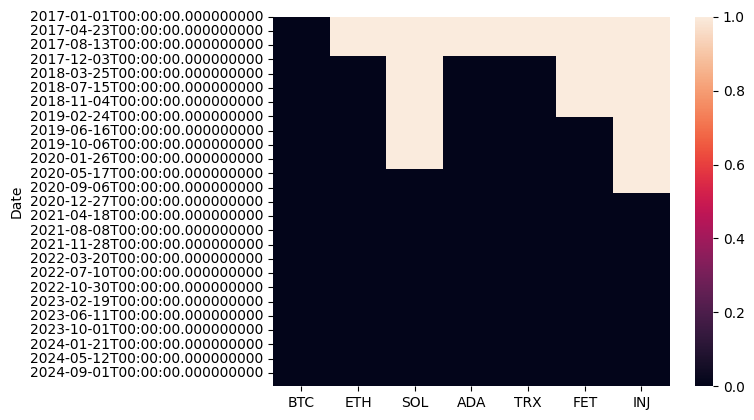

In [5]:
sns.heatmap(cryptos_df.isnull())

In [6]:
#apaga registros nulos
cryptos_df.dropna(inplace=True)
cryptos_df.to_csv('acoes.csv')
cryptos_df

BTC          ETH         SOL       ADA       TRX  \
Date                                                                     
2020-10-21   12823.689453   392.189972    1.890378  0.106187  0.026721   
2020-10-22   12965.891602   413.772980    1.955653  0.110572  0.027042   
2020-10-23   12931.539062   409.766693    1.960035  0.108083  0.026691   
2020-10-24   13108.062500   412.457611    1.911828  0.108075  0.027050   
2020-10-25   13031.173828   406.217773    1.787459  0.106351  0.026935   
...                   ...          ...         ...       ...       ...   
2024-12-11  101173.031250  3832.822021  227.446838  1.088890  0.282482   
2024-12-12  100043.000000  3883.101562  227.026718  1.125016  0.297226   
2024-12-13  101459.257812  3911.205322  224.837296  1.119602  0.290659   
2024-12-14  101372.968750  3868.405273  219.840759  1.060512  0.282244   
2024-12-15  103144.656250  3897.762207  220.946732  1.089083  0.284545   

                 FET        INJ  
Date                             
2020-10-21  0.045765   0.773266  
2020-10-22  0.049113   0.789443  
2020-10-23  0.053041   1.183961  
2020-10-24  0.056407   0.965414  
2020-10-25  0.051211   0.901291  
...              ...        ...  
2024-12-11  1.819680  28.845022  
2024-12-12  1.788548  29.055593  
2024-12-13  1.801379  29.262098  
2024-12-14  1.730510  27.436207  
2024-12-15  1.761710  27.971495  

[1517 rows x 7 columns]

### Visualização dos dados 

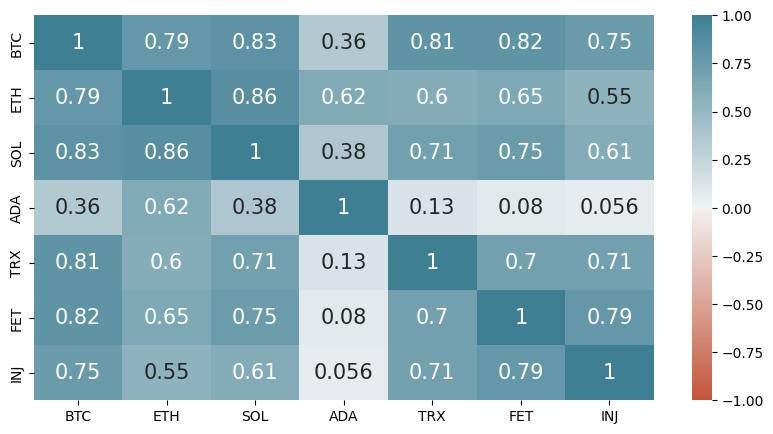

In [7]:
fig, axes = plt.subplots(1, 1, figsize=(10,5))

columns=cryptos_df.columns
corrmat = cryptos_df[columns].corr()
mask= np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corrmat,
            vmax=1, vmin=-1,
            annot=True, annot_kws={'fontsize':15},
            cmap=sns.diverging_palette(20,220,as_cmap=True))
plt.show()

In [8]:
cryptos_df.iloc[0].values

array([1.28236895e+04, 3.92189972e+02, 1.89037800e+00, 1.06187001e-01,
       2.67210007e-02, 4.57650013e-02, 7.73266017e-01])

In [9]:
# Normaliza os dados
cryptos_df_normalized = cryptos_df / cryptos_df.iloc[0].values

In [10]:
cryptos_df_normalized

BTC       ETH         SOL        ADA        TRX        FET  \
Date                                                                          
2020-10-21  1.000000  1.000000    1.000000   1.000000   1.000000   1.000000   
2020-10-22  1.011089  1.055032    1.034530   1.041295   1.012013   1.073156   
2020-10-23  1.008410  1.044817    1.036848   1.017855   0.998877   1.158986   
2020-10-24  1.022176  1.051678    1.011347   1.017780   1.012312   1.232536   
2020-10-25  1.016180  1.035768    0.945556   1.001544   1.008009   1.118999   
...              ...       ...         ...        ...        ...        ...   
2024-12-11  7.889542  9.772871  120.318179  10.254456  10.571535  39.761388   
2024-12-12  7.801421  9.901073  120.095938  10.594668  11.123311  39.081131   
2024-12-13  7.911862  9.972732  118.937745  10.543682  10.877550  39.361497   
2024-12-14  7.905133  9.863601  116.294603   9.987211  10.562628  37.812956   
2024-12-15  8.043290  9.938455  116.879657  10.256276  10.648755  38.494709   

                  INJ  
Date                   
2020-10-21   1.000000  
2020-10-22   1.020920  
2020-10-23   1.531117  
2020-10-24   1.248489  
2020-10-25   1.165564  
...               ...  
2024-12-11  37.302845  
2024-12-12  37.575159  
2024-12-13  37.842214  
2024-12-14  35.480942  
2024-12-15  36.173185  

[1517 rows x 7 columns]

In [11]:
#%% Carregando dados
cryptos_df=pd.read_csv('acoes.csv')
cryptos_df['Date']=pd.to_datetime(cryptos_df['Date'])
cryptos_df=cryptos_df.set_index('Date')
for col in cryptos_df.columns:
    cryptos_df[col]=cryptos_df[col].astype('float32')

In [12]:
cryptos_df_normalized = cryptos_df / cryptos_df.iloc[0].values

In [13]:
# Cria um gráfico de linha usando o Plotly
fig = go.Figure()
for cryptos in cryptos_df.columns:
#fig.add_trace(go.Scatter(x=cryptos_df.index, y=cryptos_df['IBOV'], mode='lines', name='Preço do Ibovespa'))
#fig.add_trace(go.Scatter(x=cryptos_df.index, y=cryptos_df['B3SA3'], mode='lines', name='Preço do B3SA3'))
    fig.add_trace(go.Scatter(x=cryptos_df_normalized.index, y=cryptos_df_normalized[cryptos], mode='lines', name=f'Preço do {cryptos}'))

# Configura o layout do gráfico
fig.update_layout(
    title='Preço do Ibovespa e ações',
    xaxis_title='Data',
    yaxis_title='Preço',
    showlegend=True
)

# Exibe o gráfico
fig.show()

## Indicadores de tendência e Séries Temporais 

Os swing traders geralmente utilizam médias móveis exponenciais (EMAs) de diferentes períodos para identificar tendências e sinais de compra e venda. As EMAs mais utilizadas pelos swing traders incluem:

-EMA de 9 períodos: A EMA de 9 períodos é comumente usada para identificar sinais de curto prazo e capturar movimentos rápidos do mercado. Pode fornecer sinais mais sensíveis e frequentes.

-EMA de 20 períodos: A EMA de 20 períodos é amplamente utilizada e considerada uma média móvel de curto prazo. É usada para identificar a direção da tendência de curto prazo e possíveis pontos de reversão.

-EMA de 50 períodos: A EMA de 50 períodos é frequentemente usada para identificar a direção da tendência de médio prazo. É uma média móvel amplamente observada pelos swing traders.

-EMA de 100 períodos: A EMA de 100 períodos é usada para identificar a direção da tendência de médio a longo prazo. É útil para identificar pontos de entrada e saída em operações de swing trading mais prolongadas.

-EMA de 200 períodos: A EMA de 200 períodos é uma das médias móveis mais amplamente observadas e é usada para identificar a direção da tendência de longo prazo. É frequentemente usada como um indicador-chave para determinar a tendência geral do mercado.

In [14]:
import pandas as pd
import pandas_datareader as pdr
from pandas_datareader import data 
import datetime
import plotly.graph_objects as go

# Define o código de ticker da crypto
ticker = "BTC"


ticker=ticker+"-USD"

# Obtém os dados históricos da crypto
df = data.DataReader(ticker, start='2013-01-01')


[*********************100%%**********************]  1 of 1 completed


In [15]:
df.iloc[-10:,:]

Open           High            Low          Close  \
Date                                                                     
2024-12-06   97074.226562  102039.882812   96514.875000   99920.710938   
2024-12-07   99916.710938  100563.382812   99030.882812   99923.335938   
2024-12-08   99921.914062  101399.992188   98771.515625  101236.015625   
2024-12-09  101237.062500  101272.507812   94355.914062   97432.718750   
2024-12-10   97441.234375   98270.156250   94321.257812   96675.429688   
2024-12-11   96656.062500  101913.359375   95747.226562  101173.031250   
2024-12-12  101167.804688  102524.914062   99339.953125  100043.000000   
2024-12-13  100046.648438  101888.804688   99233.281250  101459.257812   
2024-12-14  101451.437500  102618.882812  100634.054688  101372.968750   
2024-12-15  101393.679688  103331.328125  101271.093750  103186.640625   

                Adj Close        Volume  
Date                                     
2024-12-06   99920.710938   94534772658  
2024-12-07   99923.335938   44177510897  
2024-12-08  101236.015625   44125751925  
2024-12-09   97432.718750  110676473908  
2024-12-10   96675.429688  104823780634  
2024-12-11  101173.031250   85391409936  
2024-12-12  100043.000000   72073983533  
2024-12-13  101459.257812   56894751583  
2024-12-14  101372.968750   40422968793  
2024-12-15  103186.640625   43161387008

In [16]:
scaler = MinMaxScaler()
y=scaler.fit_transform(df['Close'].values.reshape(-1,1))

# Function to compute Simple Moving Average (SMA)b
def calculate_sma(data, window):
    return data['Close'].rolling(window=window).mean()

# Function to compute Relative Strength Index (RSI)
def calculate_rsi(data, window):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Function to compute Moving Average Convergence Divergence (MACD)
def calculate_macd(data, short_window, long_window, signal_window):
    short_ema = data['Close'].ewm(span=short_window, min_periods=1, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, min_periods=1, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_window, min_periods=1, adjust=False).mean()
    return macd_line, signal_line

def calculate_bollinger_bands(data, window=20, num_std=2):
    sma = data['Close'].rolling(window=window).mean()
    std = data['Close'].rolling(window=window).std()
    upper_band = sma + num_std * std
    lower_band = sma - num_std * std
    return upper_band, lower_band

df['upper_band_bollinger'],df['lower_band_bollinger']=calculate_bollinger_bands(df)
# Calcula as EMAs de 9 e 20 períodos
df['EMA9'] = df['Close'].ewm(span=9).mean()
df['EMA20'] = df['Close'].ewm(span=20).mean()
df['EMA50'] = df['Close'].ewm(span=50).mean()
df['EMA100'] = df['Close'].ewm(span=100).mean()
df['EMA200'] = df['Close'].ewm(span=200).mean()
df['MA111'] = df['Close'].rolling(window=111).mean()
df['MA350'] = df['Close'].rolling(window=350).mean() 
df['MA111*2'] = df['Close'].rolling(window=111).mean() * 2
df['MA350*2'] = df['Close'].rolling(window=350).mean() * 2


# Calculate RSI (14-period)
df['RSI_14'] = calculate_rsi(df, window=14)

# Calculate MACD (12, 26, 9)
df['MACD'], df['Signal'] = calculate_macd(df, short_window=12, long_window=26, signal_window=9)


In [17]:
# Cria um gráfico de candlestick usando o Plotly
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'],
                name='Candlestick')])

# Adiciona as médias móveis ao gráfico
fig.add_trace(go.Scatter(x=df.index, y=df['EMA9'], mode='lines', name='EMA9'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA20'], mode='lines', name='EMA20'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA50'], mode='lines', name='EMA50'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA100'], mode='lines', name='EMA100'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA200'], mode='lines', name='EMA200'))
fig.add_trace(go.Scatter(x=df.index, y=df['MA111'], mode='lines', name='MA111'))
fig.add_trace(go.Scatter(x=df.index, y=df['MA350'], mode='lines', name='MA350'))
fig.add_trace(go.Scatter(x=df.index, y=df['MA111*2'], mode='lines', name='MA111*2'))
fig.add_trace(go.Scatter(x=df.index, y=df['MA350*2'], mode='lines', name='MA350*2'))

if ticker=="^BVSP":
    ticker='IBOV'

# Configura o layout do gráfico
fig.update_layout(
    width=1500,
    height=700,
    title=f"Gráfico de Candlestick e Médias Móveis para {ticker}",
    xaxis_title="Data",
    yaxis_title="Preço",
    showlegend=True
)

# Exibe o gráfico
fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()


In [18]:
# Cria um gráfico de candlestick usando o Plotly
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'],
                name='Candlestick')])

# Adiciona as médias móveis ao gráfico
fig.add_trace(go.Scatter(x=df.index, y=df['upper_band_bollinger'], mode='lines', name='upper band bollinger'))
fig.add_trace(go.Scatter(x=df.index, y=df['lower_band_bollinger'], mode='lines', name='lower band bollinger'))


# Configura o layout do gráfico
fig.update_layout(
    width=1500,
    height=700,
    title=f"Gráfico de Candlestick e Médias Móveis para {ticker}",
    xaxis_title="Data",
    yaxis_title="Preço",
    showlegend=True
)
fig.update_layout(xaxis_rangeslider_visible=False)

# Exibe o gráfico
fig.show()


In [19]:
def labelling_method(close_price_list, window_days=11):
    window_size = window_days  # Tamanho da janela deslizante
    number_of_days = len(close_price_list)  # Total de dias no arquivo
    labels = []  # Lista para armazenar os rótulos
    
    for counter_row in range(number_of_days):
        if counter_row >= window_size:
            # Define os índices da janela
            window_begin_index = counter_row - window_size
            window_end_index = counter_row - 1
            window_middle_index = (window_begin_index + window_end_index) // 2

            # Inicializa variáveis de máximo e mínimo
            min_price = float('inf')
            max_price = float('-inf')
            min_index = -1
            max_index = -1

            # Percorre a janela para identificar máximos e mínimos
            for i in range(window_begin_index, window_end_index + 1):
                price = close_price_list[i]
                if price < min_price:
                    min_price = price
                    min_index = i
                if price > max_price:
                    max_price = price
                    max_index = i

            # Rotula o dia central
            if max_index == window_middle_index:
                labels.append("SELL")
            elif min_index == window_middle_index:
                labels.append("BUY")
            else:
                labels.append("HOLD")
        else:
            # Não é possível rotular dias antes de preencher a janela
            labels.append('HOLD')

    return labels

def label_data(data, window=10, buy_threshold=0.10, sell_threshold=-0.10):
    labels = []  # Store labels

    for i in range(len(data)):
        if i + window >= len(data):  # If the window exceeds data length
            labels.append("HOLD")
            continue

        current_price = data[i]
        future_prices = data[i+1:i+1+window]
        returns = (future_prices - current_price) / current_price

        if max(returns) >= buy_threshold:
            labels.append("BUY")
        elif min(returns) <= sell_threshold:
            labels.append("SELL")
        else:
            labels.append("HOLD")
    
    return labels

def backtest(close_price_list, labels, initial_capital=10000, verbose=0):
    """
    Backtests a trading strategy based on buy/sell signals.

    Args:
        close_price_list: A list of closing prices for each period.
        labels: A list of trading signals ("BUY", "SELL", or "HOLD").
        initial_capital: The initial capital for the backtest.
        verbose: An integer controlling verbosity: 0 (no output), 1 (prints buy/sell actions), 2 (prints all actions and portfolio value).

    Returns:
        A list of portfolio values at each period.
    """
    cash = initial_capital  # Dinheiro em caixa
    shares = 0  # Quantidade de ações
    portfolio_values = []  # Histórico do valor total do portfólio
    
    for i, label in enumerate(labels):
        price = close_price_list[i]
        
        if label == "BUY" and cash >= price:
            shares_to_buy = cash // price
            shares += shares_to_buy
            cash -= shares_to_buy * price
            if verbose >= 1:
                print(f"BUY: Comprado {shares_to_buy} ações a R$ {price:.2f}")

        elif label == "SELL" and shares > 0:
            cash += shares * price
            shares = 0
            if verbose >= 1:
                print(f"SELL: Vendido {shares} ações a R$ {price:.2f}")

        # Valor atual do portfólio
        portfolio_value = cash + shares * price
        portfolio_values.append(portfolio_value)
        if verbose >= 2:
            print(f"Periodo {i+1}: Portfólio = R$ {portfolio_value:.2f}")

    # Resultado final
    final_value = cash + shares * close_price_list[-1]
    if verbose >= 1:
        print(f"Valor final do portfólio: R$ {final_value:.2f}")
        print(f"Retorno total: {((final_value - initial_capital) / initial_capital) * 100:.2f}%")

    return portfolio_values


In [20]:


# Dados de exemplo
close_price_list = df['Close'].values

#labels = labelling_method(close_price_list, 60)
labels = label_data(df['Close'], window=7, buy_threshold=0.05, sell_threshold=-0.05)
print(np.unique(labels, return_counts=True))
# Realizar o backtest
portfolio_values = backtest(close_price_list, labels, initial_capital=100)

# Gráfico do desempenho
import plotly.graph_objects as go

#fig = go.Figure()

fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'],
                name='Candlestick')])

# Preço da ação
#fig.add_trace(go.Scatter(
#    x=df.index,
#    y=close_price_list,
#    mode='lines',
#    name='Preço da Ação'
#))

# Valor do portfólio
fig.add_trace(go.Scatter(
    x=df.index,
    y=portfolio_values,
    mode='lines',
    name='Valor do Portfólio'
))

# Configuração do layout
fig.update_layout(
    title="Backtest de Estratégia de BUY, SELL, HOLD",
    xaxis_title="Data",
    yaxis_title="Valor",
    #showlegend=True
)


# Adiciona os marcadores BUY, SELL e HOLD
for i, label in enumerate(labels):
    if label == "BUY":
        fig.add_trace(go.Scatter(
            x=[df.index[i]],
            y=[df['Close'].iloc[i]],
            mode='markers',
            marker=dict(color='green', size=10, symbol='triangle-up'),
            name='BUY'
        ))
    elif label == "SELL":
        fig.add_trace(go.Scatter(
            x=[df.index[i]],
            y=[df['Close'].iloc[i]],
            mode='markers',
            marker=dict(color='yellow', size=10, symbol='triangle-down'),
            name='SELL'
        ))
fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_10692\914976863.py:50: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



(array(['BUY', 'HOLD', 'SELL'], dtype='<U4'), array([1495, 1261,  987], dtype=int64))


In [21]:

# Calcular a variação percentual entre o preço de fechamento de um dia e o dia seguinte
df['Variation'] = ((df['Close'] - df['Close'].shift(+1)) / df['Close'])*100
#pred_data_df['Variacao'] = ((pred_data_df['pred']-pred_data_df['pred'].shift(+1)) / pred_data_df['pred'])*100


# Thresholds for variation classification
positive_threshold = 0.03
negative_threshold = -0.03

# Create a new column for classified variation
df['Classification'] = df['Variation'].apply(lambda x: 
                                            1 if x > positive_threshold else (
                                                -1 if x < negative_threshold else 0))

#df['week']=df.index.week
df['weekday']=df.index.weekday+1
df['day']=df.index.day
df['month']=df.index.month
df['quarter']=df.index.quarter

df=df.reset_index().fillna(0)
df


Date           Open           High            Low          Close  \
0    2014-09-17     465.864014     468.174011     452.421997     457.334015   
1    2014-09-18     456.859985     456.859985     413.104004     424.440002   
2    2014-09-19     424.102997     427.834991     384.532013     394.795990   
3    2014-09-20     394.673004     423.295990     389.882996     408.903992   
4    2014-09-21     408.084991     412.425995     393.181000     398.821014   
...         ...            ...            ...            ...            ...   
3738 2024-12-11   96656.062500  101913.359375   95747.226562  101173.031250   
3739 2024-12-12  101167.804688  102524.914062   99339.953125  100043.000000   
3740 2024-12-13  100046.648438  101888.804688   99233.281250  101459.257812   
3741 2024-12-14  101451.437500  102618.882812  100634.054688  101372.968750   
3742 2024-12-15  101393.679688  103331.328125  101271.093750  103186.640625   

          Adj Close       Volume  upper_band_bollinger  lower_band_bollinger  \
0        457.334015     21056800              0.000000              0.000000   
1        424.440002     34483200              0.000000              0.000000   
2        394.795990     37919700              0.000000              0.000000   
3        408.903992     36863600              0.000000              0.000000   
4        398.821014     26580100              0.000000              0.000000   
...             ...          ...                   ...                   ...   
3738  101173.031250  85391409936         102032.786631          92594.469619   
3739  100043.000000  72073983533         102185.668408          92546.121435   
3740  101459.257812  56894751583         102705.513258          92394.474242   
3741  101372.968750  40422968793         103148.621781          92287.280563   
3742  103186.640625  43161387008         103720.598199          92723.738520   

               EMA9  ...        MA350*2     RSI_14         MACD       Signal  \
0        457.334015  ...       0.000000   0.000000     0.000000     0.000000   
1        439.059564  ...       0.000000   0.000000    -2.624024    -0.524805   
2        420.918755  ...       0.000000   0.000000    -7.014744    -1.822793   
3        416.848713  ...       0.000000   0.000000    -9.249402    -3.308115   
4        411.485880  ...       0.000000   0.000000   -11.699137    -4.986319   
...             ...  ...            ...        ...          ...          ...   
3738   98561.305049  ...  127700.940982  60.785273  3483.779130  4048.830814   
3739   98857.644039  ...  128029.027522  58.789643  3382.945703  3915.653792   
3740   99377.966794  ...  128368.226696  58.131163  3378.370898  3808.197213   
3741   99776.967185  ...  128706.604219  60.407054  3329.403238  3712.438418   
3742  100458.901873  ...  129054.726808  61.986523  3397.776722  3649.506079   

      Variation  Classification  weekday  day  month  quarter  
0      0.000000               0        3   17      9        3  
1     -7.749979              -1        4   18      9        3  
2     -7.508691              -1        5   19      9        3  
3      3.450199               1        6   20      9        3  
4     -2.528196              -1        7   21      9        3  
...         ...             ...      ...  ...    ...      ...  
3738   4.445455               1        3   11     12        4  
3739  -1.129546              -1        4   12     12        4  
3740   1.395888               1        5   13     12        4  
3741  -0.085120              -1        6   14     12        4  
3742   1.757662               1        7   15     12        4  

[3743 rows x 27 columns]

## Data preprocessing to stock forecast

In [22]:
del acao, axes, close_price_list, col, columns, corrmat, cryptos, cryptos_df, cryptos_df_normalized, fig, 

In [23]:
import requests
import pandas as pd
import numpy as np

# Lista de criptomoedas
cryptos = ['FET']
peso_cryptos = np.ones(len(cryptos)) * 1 / len(cryptos)

# Adiciona o par USD para cada cripto
cryptos = [crypto + "USDT" for crypto in cryptos]

# Função para baixar dados históricos da Binance API
def get_binance_data(symbol, interval='1d', start_time='2017-01-01'):
    base_url = "https://api.binance.com/api/v3/klines"
    end_time = int(pd.Timestamp.now().timestamp() * 1000)  # Data atual

    # Converte a data de início para timestamp
    start_timestamp = int(pd.Timestamp(start_time).timestamp() * 1000)

    # Lista para armazenar os dados
    data_list = []

    # Faça requisições iterativas até obter todos os dados
    while start_timestamp < end_time:
        params = {
            'symbol': symbol,
            'interval': interval,
            'startTime': start_timestamp,
            'endTime': start_timestamp + (1000 * 60 * 60 * 24 * 365),  # Intervalo de 1 ano
            'limit': 1000  # Máximo de registros por chamada
        }

        # Coleta dados da API
        response = requests.get(base_url, params=params)
        data = response.json()

        # Verifica se a resposta da API está vazia
        if not data:
            break

        # Converte os dados em DataFrame
        df = pd.DataFrame(data, columns=[
            'timestamp', 'open', 'high', 'low', 'close', 'volume',
            'close_time', 'quote_asset_volume', 'number_of_trades',
            'taker_buy_base', 'taker_buy_quote', 'ignore'
        ])

        # Verifica se o DataFrame está vazio
        if df.empty:
            break

        # Adiciona os dados à lista
        data_list.append(df)

        # Atualiza o start_timestamp para a próxima requisição
        if not df.empty:
            start_timestamp = int(df['timestamp'].iloc[-1]) + 1000  # Adiciona 1 segundo ao último timestamp
        else:
            break

    # Concatena todos os DataFrames
    if data_list:
        df = pd.concat(data_list, ignore_index=True)
    else:
        df = pd.DataFrame()

    # Formata e filtra os dados necessários
    if not df.empty:
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)
        df['close'] = df['close'].astype(float)
        df['low'] = df['low'].astype(float)
        df['high'] = df['high'].astype(float)
        df['open'] = df['open'].astype(float)
        df['volume'] = df['volume'].astype(float)
    return df


# Intervalos disponíveis
intervals = ['1m', '3m', '5m', '15m', '30m', '1h', '2h', '4h', '6h', '8h', '12h', '1d', '3d', '1w', '1M']

#choice = int(input("Escolha um intervalo (número): "))
#interval = intervals[choice - 1]
interval ='4h'

# Baixar e consolidar dados em um DataFrame
cryptos_df = pd.DataFrame()
for crypto in cryptos:
    data = get_binance_data(crypto, start_time='2019-01-01', interval=interval)
    # Ajusta o nome da coluna removendo "USDT" antes de adicionar ao DF
    #data.columns = [crypto.replace('USDT', '')]
    if cryptos_df.empty:
        cryptos_df = data
    else:
        cryptos_df = pd.concat([cryptos_df, data], axis=1)

if not cryptos_df.empty:
    cryptos_df = cryptos_df.rename(columns={
        'open': 'Open',
        'high': 'High',
        'low': 'Low',
        'close': 'Close',
        'volume': 'Volume',
    })
    # Visualização dos dados
    cryptos_df=cryptos_df.rename_axis('Date')
    print(cryptos_df.shape)
else:
    print("Nenhum dado encontrado para o símbolo e intervalo especificados.")

df=cryptos_df
df.reset_index(inplace= True)


(12700, 11)


### Pré-processamento dos dados para predição 

In [24]:

import os, sys
processing_source_path = os.path.abspath('Processing/')
if(processing_source_path not in sys.path):
    sys.path.append(processing_source_path)
from ProcessingPipeline import FeaturesDataGenerator

In [25]:
split_data=FeaturesDataGenerator().split_data

self.pred_days 1
input data shape (19, 1, 23)
output data shape (19, 3)


d:\Projetos_python\Time_Series_Forecast\acoes\Processing\ProcessingPipeline.py:656: RuntimeWarning:

invalid value encountered in divide

d:\Projetos_python\Time_Series_Forecast\acoes\Processing\ProcessingPipeline.py:294: RuntimeWarning:

invalid value encountered in divide

d:\Projetos_python\Time_Series_Forecast\acoes\Processing\ProcessingPipeline.py:303: RuntimeWarning:

invalid value encountered in divide

d:\Projetos_python\Time_Series_Forecast\acoes\Processing\ProcessingPipeline.py:311: RuntimeWarning:

invalid value encountered in divide

d:\Projetos_python\Time_Series_Forecast\acoes\Processing\ProcessingPipeline.py:665: RuntimeWarning:

invalid value encountered in scalar divide



In [26]:
# separa os dados em Treino e Teste
split_data=FeaturesDataGenerator().split_data
X_train, X_val, T_train, T_val=split_data(df['Close'].values, df['Date'], factor=0.7)
X_val, X_test, T_val, T_test=split_data(X_val.T, T_val, factor=0.7)

print('Train data shape',X_train.shape)
print('Vall data shape',X_val.shape)
print('Test data shape',X_test.shape)


self.pred_days 1
input data shape (19, 1, 23)
output data shape (19, 3)
Train data shape (8890,)
Vall data shape (2668,)
Test data shape (1144,)


In [27]:
#features_indicators=FeaturesDataGenerator().features_name
#features_indicators=['Data_lookback','variations','EMA9', 'EMA20', 'EMA50', 'EMA100', 'EMA200']
features_indicators=['Data_lookback', 'Volume',
                     'EMA9', 'EMA20', 'EMA50', 'EMA100', 'EMA200','MA111', 'MA350','MACD']

#features_indicators=['Data_lookback','EMA9', 'EMA20', 'EMA50', 'EMA100', 'EMA200','MA111', 'MA350','MACD',]
features_indicators=['Data_lookback', 'Volume', 'Low', 'High', 'Open','EMA9', 'EMA20', 'EMA50', 'EMA100', 'EMA200','MA111', 'MA350','MACD']

features_indicators=['Data_lookback', 'Open', 'High', 'Low', 'Volume', 
                    'EMA9', 'EMA20', 'EMA50', 'EMA100', 'EMA200', 'MA111', 'MA350', 
                    'MACD', 'MACD_Signal', 'MACD_Histogram', 'RSI_14', 'CCI',  
                    'Stochastic_K', 'Stochastic_D', 
                    'Bollinger_Bands_Upper', 'Bollinger_Bands_Middle', 'Bollinger_Bands_Lower']


pred_days = int(24/4 * 12) 
buy_sell_threshold=[0.05,-0.05]
lookback = 24
batch_size = 16
shuffle = True
X_data_gen_train = FeaturesDataGenerator(df[df['Date'].isin(T_train)].iloc[:,:], lookback = lookback, pred_days = pred_days, buy_sell_threshold=buy_sell_threshold, shuffle= shuffle, batch_size=batch_size, selected_features = features_indicators, data_augmentation=False)
X_data_gen_val = FeaturesDataGenerator(df[df['Date'].isin(T_val)].iloc[:,:], lookback = lookback, pred_days = pred_days,  buy_sell_threshold=buy_sell_threshold, shuffle= shuffle, batch_size=batch_size, selected_features = features_indicators, data_augmentation=False)
X_data_gen_test = FeaturesDataGenerator(df[df['Date'].isin(T_test)].iloc[:,:], lookback = lookback, pred_days = pred_days,  buy_sell_threshold=buy_sell_threshold, shuffle= False, batch_size=batch_size, selected_features = features_indicators, data_augmentation=False)

self.pred_days 72


d:\Projetos_python\Time_Series_Forecast\acoes\Processing\ProcessingPipeline.py:294: RuntimeWarning:

divide by zero encountered in divide



input data shape (8866, 24, 22)
output data shape (8866, 3)
self.pred_days 72
input data shape (2644, 24, 22)
output data shape (2644, 3)
self.pred_days 72
input data shape (1120, 24, 22)
output data shape (1120, 3)


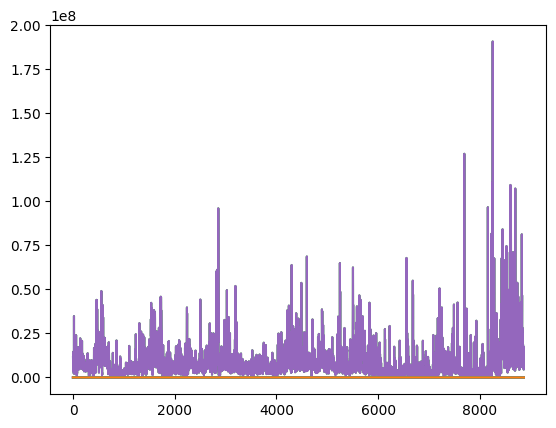

In [28]:
plt.plot(X_data_gen_train.features[:,-1,:])
plt.show()

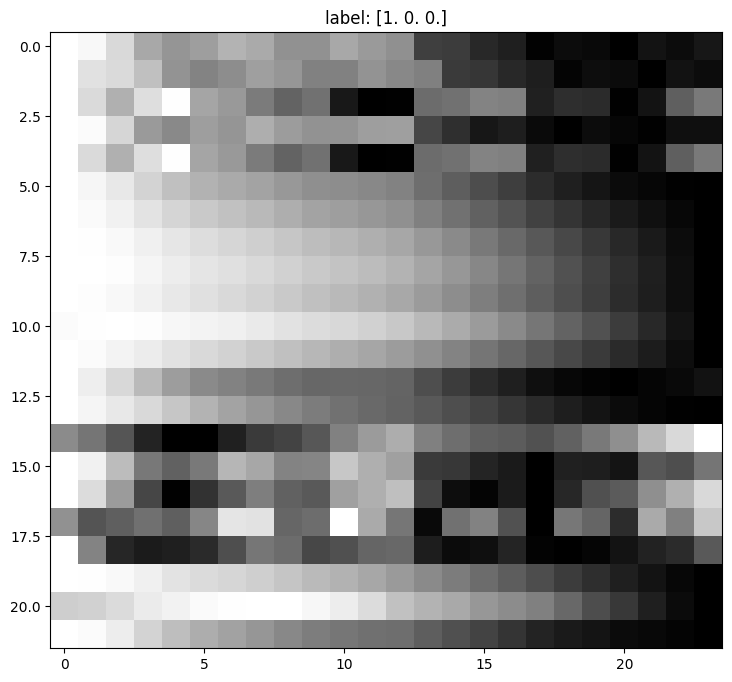

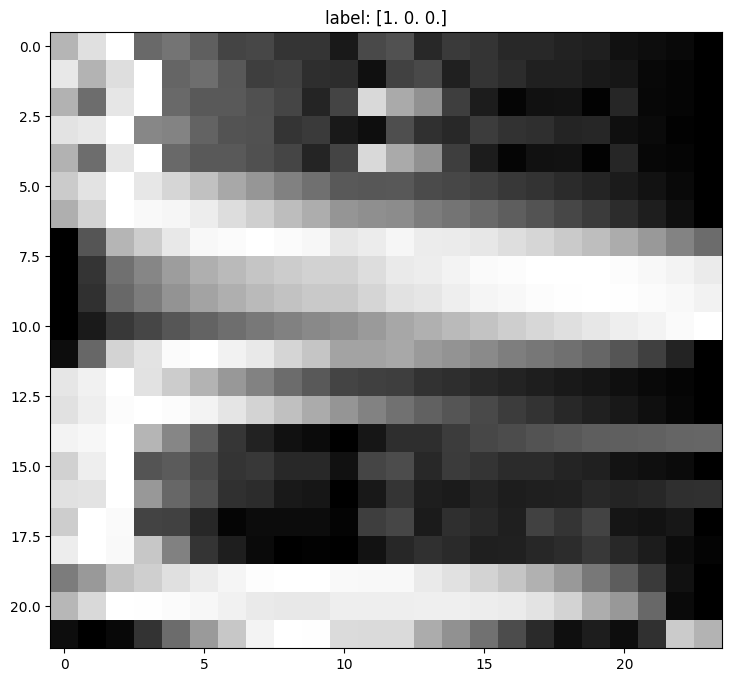

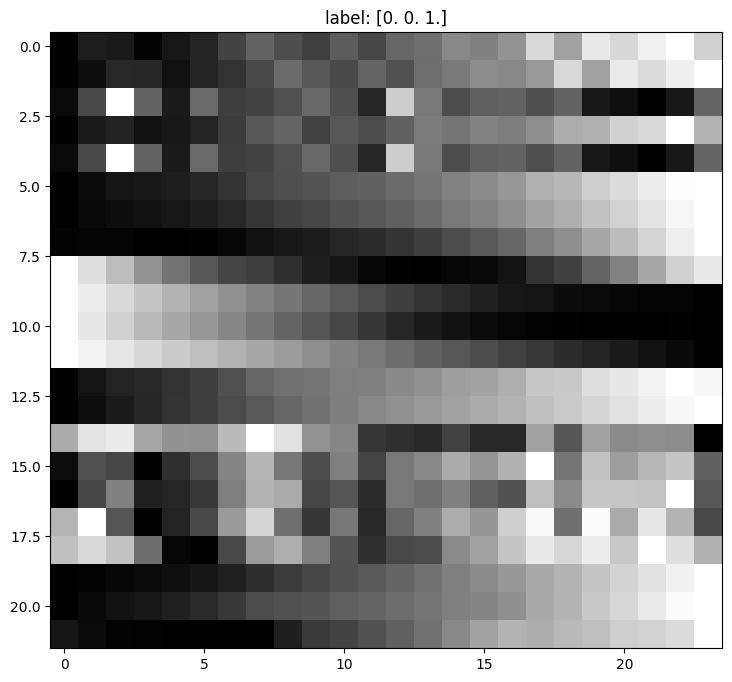

In [29]:
for idx, data_2d in enumerate(np.array(X_data_gen_train[15][0][:3])):
    plt.figure(figsize=(15,8))
    # Visualize the image
    plt.imshow(data_2d.T, cmap='gray', interpolation='nearest')
    plt.title('label: {}'.format(X_data_gen_train[15][1][idx]))

    #plt.colorbar()
    plt.show()

In [30]:
input_data= X_data_gen_test.InputData['Close'][lookback:].values.reshape(-1,1)
input_data.shape


(1120, 1)

In [31]:
np.diff(X_data_gen_test.InputData['Close'])[lookback-1:].shape

(1120,)

In [32]:
#aux_data=np.hstack([X_data_gen_test.variations.reshape(-1,1),X_data_gen_test.features[:,0].reshape(-1,1),X_data_gen_test.y_classification])
input_data= X_data_gen_test.InputData['Close'][lookback:].values.reshape(-1,1)
variations = np.diff(X_data_gen_test.InputData['Close'])[lookback-1:]

aux_data=np.hstack([variations.reshape(-1,1), input_data, X_data_gen_test.y_classification])

#recomentations_2=pd.DataFrame(data=aux_data,columns=['var','X', 'Hold','Buy','Strong_Buy','Sell','Strong_Sell'])
recomentations_2=pd.DataFrame(data=aux_data,columns=['var','X', 'Hold','Buy','Sell'])
recomentations_2.tail(20)    


var      X  Hold  Buy  Sell
1100  0.026  1.849   1.0  0.0   0.0
1101 -0.069  1.780   1.0  0.0   0.0
1102  0.007  1.787   1.0  0.0   0.0
1103  0.013  1.800   1.0  0.0   0.0
1104 -0.041  1.759   1.0  0.0   0.0
1105  0.015  1.774   1.0  0.0   0.0
1106 -0.016  1.758   1.0  0.0   0.0
1107  0.020  1.778   1.0  0.0   0.0
1108  0.027  1.805   1.0  0.0   0.0
1109 -0.014  1.791   1.0  0.0   0.0
1110  0.002  1.793   1.0  0.0   0.0
1111 -0.032  1.761   1.0  0.0   0.0
1112 -0.031  1.730   1.0  0.0   0.0
1113 -0.018  1.712   1.0  0.0   0.0
1114  0.019  1.731   1.0  0.0   0.0
1115 -0.017  1.714   1.0  0.0   0.0
1116 -0.031  1.683   1.0  0.0   0.0
1117  0.030  1.713   1.0  0.0   0.0
1118  0.051  1.764   1.0  0.0   0.0
1119  0.009  1.773   1.0  0.0   0.0

In [33]:
X_data_gen_test.InputData

Date   Open   High    Low  Close     Volume  \
11556 2024-06-08 04:00:00  1.846  1.852  1.813  1.828  1617783.9   
11557 2024-06-08 08:00:00  1.827  1.829  1.749  1.754  5242805.6   
11558 2024-06-08 12:00:00  1.753  1.777  1.700  1.744  6916505.2   
11559 2024-06-08 16:00:00  1.745  1.757  1.703  1.734  4014867.5   
11560 2024-06-08 20:00:00  1.734  1.751  1.723  1.745  2692660.5   
...                   ...    ...    ...    ...    ...        ...   
12695 2024-12-15 00:00:00  1.731  1.747  1.706  1.714  2622153.7   
12696 2024-12-15 04:00:00  1.714  1.739  1.662  1.683  3972802.1   
12697 2024-12-15 08:00:00  1.683  1.719  1.677  1.713  3144950.2   
12698 2024-12-15 12:00:00  1.713  1.777  1.711  1.764  6284155.4   
12699 2024-12-15 16:00:00  1.765  1.791  1.754  1.773  4376916.7   

          close_time quote_asset_volume  number_of_trades    taker_buy_base  \
11556  1717833599999   2961424.05340000              9919   674170.20000000   
11557  1717847999999   9396031.61940000             28693  2340312.60000000   
11558  1717862399999  12036909.13100000             40436  3418965.50000000   
11559  1717876799999   6944220.83070000             26949  1999200.40000000   
11560  1717891199999   4676349.95170000             16113  1469090.60000000   
...              ...                ...               ...               ...   
12695  1734235199999   4537630.73070000             27232  1259512.30000000   
12696  1734249599999   6740077.16310000             23121  1788804.70000000   
12697  1734263999999   5355002.94480000             19396  1639145.80000000   
12698  1734278399999  10995634.13510000             32534  3652056.90000000   
12699  1734292799999   7745008.95540000             20652  2295049.30000000   

        taker_buy_quote ignore  
11556  1234450.43250000      0  
11557  4196019.97010000      0  
11558  5957237.53360000      0  
11559  3459239.26020000      0  
11560  2552472.95310000      0  
...                 ...    ...  
12695  2180283.96360000      0  
12696  3039929.15050000      0  
12697  2791934.44870000      0  
12698  6388377.79210000      0  
12699  4062465.95380000      0  

[1144 rows x 12 columns]

In [34]:
X_data_gen_test.InputData

Date   Open   High    Low  Close     Volume  \
11556 2024-06-08 04:00:00  1.846  1.852  1.813  1.828  1617783.9   
11557 2024-06-08 08:00:00  1.827  1.829  1.749  1.754  5242805.6   
11558 2024-06-08 12:00:00  1.753  1.777  1.700  1.744  6916505.2   
11559 2024-06-08 16:00:00  1.745  1.757  1.703  1.734  4014867.5   
11560 2024-06-08 20:00:00  1.734  1.751  1.723  1.745  2692660.5   
...                   ...    ...    ...    ...    ...        ...   
12695 2024-12-15 00:00:00  1.731  1.747  1.706  1.714  2622153.7   
12696 2024-12-15 04:00:00  1.714  1.739  1.662  1.683  3972802.1   
12697 2024-12-15 08:00:00  1.683  1.719  1.677  1.713  3144950.2   
12698 2024-12-15 12:00:00  1.713  1.777  1.711  1.764  6284155.4   
12699 2024-12-15 16:00:00  1.765  1.791  1.754  1.773  4376916.7   

          close_time quote_asset_volume  number_of_trades    taker_buy_base  \
11556  1717833599999   2961424.05340000              9919   674170.20000000   
11557  1717847999999   9396031.61940000             28693  2340312.60000000   
11558  1717862399999  12036909.13100000             40436  3418965.50000000   
11559  1717876799999   6944220.83070000             26949  1999200.40000000   
11560  1717891199999   4676349.95170000             16113  1469090.60000000   
...              ...                ...               ...               ...   
12695  1734235199999   4537630.73070000             27232  1259512.30000000   
12696  1734249599999   6740077.16310000             23121  1788804.70000000   
12697  1734263999999   5355002.94480000             19396  1639145.80000000   
12698  1734278399999  10995634.13510000             32534  3652056.90000000   
12699  1734292799999   7745008.95540000             20652  2295049.30000000   

        taker_buy_quote ignore  
11556  1234450.43250000      0  
11557  4196019.97010000      0  
11558  5957237.53360000      0  
11559  3459239.26020000      0  
11560  2552472.95310000      0  
...                 ...    ...  
12695  2180283.96360000      0  
12696  3039929.15050000      0  
12697  2791934.44870000      0  
12698  6388377.79210000      0  
12699  4062465.95380000      0  

[1144 rows x 12 columns]

In [35]:
# Dados de exemplo
data_idx = -500
input_data = X_data_gen_test.InputData['Close'].iloc[data_idx:].values
date = X_data_gen_test.InputData['Date'].iloc[data_idx:]
#labels = labelling_method(close_price_list, 60)

labels=[("BUY" if np.allclose(label, [0, 1, 0]) else "SELL" if np.allclose(label, [0, 0, 1]) else "HOLD") 
        for label in X_data_gen_test.y_classification]# Realizar o backtest


labels=labels[data_idx:]
print(np.unique(labels, return_counts=True))
#portfolio_values = backtest(input_data, labels, initial_capital=100000)

# Gráfico do desempenho
import plotly.graph_objects as go

#fig = go.Figure()

fig = go.Figure(data=[go.Candlestick(x=X_data_gen_test.InputData['Date'].iloc[data_idx:],
                open=X_data_gen_test.InputData['Open'].iloc[data_idx:],
                high=X_data_gen_test.InputData['High'].iloc[data_idx:],
                low=X_data_gen_test.InputData['Low'].iloc[data_idx:],
                close=X_data_gen_test.InputData['Close'].iloc[data_idx:],
                name='Candlestick')])

# Valor do portfólio
#fig.add_trace(go.Scatter(
#    x=X_data_gen_test.InputData['Date'],
#    y=portfolio_values,
#    mode='lines',
#    name='Valor do Portfólio'
#))

# Configuração do layout
fig.update_layout(
    title="Backtest de Estratégia de BUY, SELL, HOLD",
    xaxis_title="Data",
    yaxis_title="Valor",
    showlegend=False,
    width=1700,
    height=600,
    margin=dict(l=50, r=50, t=50, b=50)  # Margem esquerda, direita, superior e inferior
)


# Adiciona os marcadores BUY, SELL e HOLD
for i, label in enumerate(labels):
    if label == "BUY":
        fig.add_trace(go.Scatter(
            x=[date.iloc[i]],
            y=[input_data[i] - 0.05*input_data[i]],
            mode='markers',
            marker=dict(color='green', size=10, symbol='triangle-up'),
            name='BUY'
        ))
    elif label == "SELL":
        fig.add_trace(go.Scatter(
            x=[date.iloc[i]],
            y=[input_data[i] + 0.05*input_data[i]],
            mode='markers',
            marker=dict(color='yellow', size=10, symbol='triangle-down'),
            name='SELL'
        ))
fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()


(array(['BUY', 'HOLD', 'SELL'], dtype='<U4'), array([ 25, 447,  28], dtype=int64))


In [36]:
#recomentations_2=pd.DataFrame(data=np.hstack([np.roll(X_data_gen_train.variations.reshape(-1,1),1)[lookback:],X_data_gen_train.features[:,lookback-1].reshape(-1,1),X_data_gen_train.y_classification]),columns=['var','X', 'Hold','Buy','Sell'])
#recomentations_2.head(10)

In [37]:
'''variations = ((X_train - np.roll(X_train, 1)) / X_train) * 100
recomendations=pd.DataFrame(data=np.hstack([np.vstack([variations[lookback:-pred_days],X_train[lookback:-pred_days]]).T,X_data_gen_train.comput_outputs(X_train)]), columns=['var','X', 'Hold','Buy','Sell'])
recomendations.head(10)'''

"variations = ((X_train - np.roll(X_train, 1)) / X_train) * 100\nrecomendations=pd.DataFrame(data=np.hstack([np.vstack([variations[lookback:-pred_days],X_train[lookback:-pred_days]]).T,X_data_gen_train.comput_outputs(X_train)]), columns=['var','X', 'Hold','Buy','Sell'])\nrecomendations.head(10)"

###  Get imbalanced database 

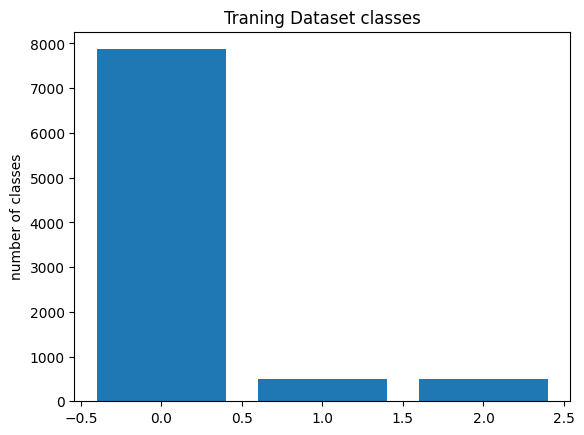

In [38]:
Y_train_categorical=np.argmax(X_data_gen_train.y_classification,axis=1)
classes, counts=np.unique(Y_train_categorical,return_counts=True) 

fig, ax = plt.subplots()
plt.bar(classes,counts)
ax.set_ylabel('number of classes')
ax.set_title('Traning Dataset classes')
plt.show()

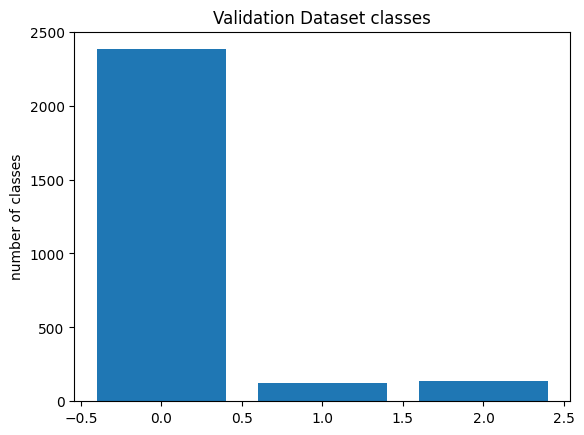

In [39]:
Y_val_categorical=np.argmax(X_data_gen_val.y_classification,axis=1)
classes, counts=np.unique(Y_val_categorical,return_counts=True) 

fig, ax = plt.subplots()
plt.bar(classes,counts)
ax.set_ylabel('number of classes')
ax.set_title('Validation Dataset classes')
plt.show()

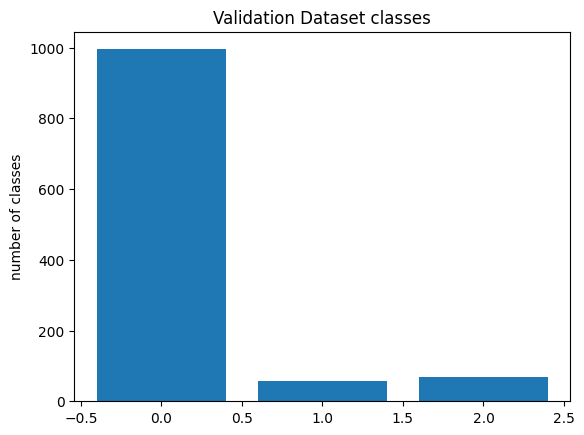

In [40]:
Y_test_categorical=np.argmax(X_data_gen_test.y_classification,axis=1)
classes, counts=np.unique(Y_test_categorical,return_counts=True) 

fig, ax = plt.subplots()
plt.bar(classes,counts)
ax.set_ylabel('number of classes')
ax.set_title('Validation Dataset classes')
plt.show()

In [41]:
n_classes=X_data_gen_train.y_classification.shape[1]

In [42]:
from sklearn.utils import class_weight
output_class_weights = class_weight.compute_class_weight('balanced', classes=np.arange(n_classes), y=np.argmax(X_data_gen_train.y_classification,axis=1))
print(output_class_weights)
weighted_categorical_crossentropy_loss= X_data_gen_train.weighted_categorical_crossentropy(output_class_weights)

[0.37551885 5.92251169 5.94634474]


## Neural Networkt aproach

In [43]:
X_data,y_data=X_data_gen_train[0]
n_classes=y_data.shape[1]
n_classes

3

### Models 1D

#### CNN_LSTM

In [44]:
# Model name
model_name = "CNN_LSTM_MultiHead"
#np.random.seed(42)

# Define CNN-LSTM feature extraction function
def CNN_LSTM(inputs):
  x = Conv1D(64, kernel_size=1, strides=1, activation='relu')(inputs)
  x = BatchNormalization()(x)
  x = MaxPooling1D(2)(x)
  x = Dropout(0.5)(x)
  return x

def CNN_bracnh(Features):
    x = Conv1D(64, kernel_size=1, strides=1, activation='relu')(Features)
    x = BatchNormalization()(x)
    x = MaxPooling1D(1)(x)
    x = Dropout(0.5)(x)
    x = Flatten()(x)
    return x
  
# Define a single function for both heads (regression and classification)
def head(features, n_outputs, activation, name= None):
  x = Dense(256)(features)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  output = Dense(n_outputs)(x)

  output = Activation(activation, name=name)(output)  # Dynamic output name

  return output

# Create the full model
input_shape = (X_data.shape[1],X_data.shape[2])  # Assuming your input shape
input_data = Input(shape=input_shape)

Features = CNN_LSTM(input_data)
#features_branch1=CNN_bracnh(Features)
features_branch2=CNN_bracnh(Features)
# Create separate heads with appropriate number of outputs and activations
#regression_output = head(features_branch1, n_outputs=pred_days, activation='linear',name='regression_head')
classification_output = head(features_branch2, n_outputs=n_classes, activation='softmax',name='classification_head')

# Create the model with two heads
model_CNN_LSTM = Model(inputs=input_data, outputs=[classification_output])
model_CNN_LSTM._name = model_name

# Print model summary
model_CNN_LSTM.summary()



Model: "CNN_LSTM_MultiHead"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24, 22)]          0         
                                                                 
 conv1d (Conv1D)             (None, 24, 64)            1472      
                                                                 
 batch_normalization (Batch  (None, 24, 64)            256       
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 12, 64)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 12, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 12, 64)   

In [45]:
X_data.shape

TensorShape([16, 24, 22])

In [46]:
# Model name
model_name = "CNN_MultiHead"
#np.random.seed(42)

def common_layers(input1):
        """Common layers to the network model

        Returns:
            Graph: the common layers model
        """

        ##################################################################
        # CNN architecture
        conv_layer = Conv1D(64, (3), padding="same")(input1)
        conv_layer = BatchNormalization()(conv_layer)
        conv_layer = Activation('relu')(conv_layer)
        conv_layer = MaxPooling1D(pool_size=(3), strides=1, padding="same")(conv_layer)
        conv_layer = Conv1D(128, (3), padding="same")(conv_layer)
        conv_layer = BatchNormalization()(conv_layer)
        conv_layer = Activation('relu')(conv_layer)
        conv_layer = MaxPooling1D(pool_size=(3), strides=2, padding="same")(conv_layer)
        
        ##################################################################

        return conv_layer

def head_layer(conv_layer, num_classes, activation='linear', output_name=None):
    
    head1 = Conv1D(64, (3), padding="same")(conv_layer)
    head1 = BatchNormalization()(head1)
    head1 = Activation('relu')(head1)
    head1 = MaxPooling1D(pool_size=(3), strides=2, padding="same")(head1)

    head1 = Dropout(0.5)(head1)
    head1 = Flatten()(head1)

    x = Dense(256)(head1)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(num_classes)(x)
    x = Activation(activation, name=output_name)(x)

    return x

# Create the full model
input_data = Input(shape=input_shape)

Features = common_layers(input_data)
# Create separate heads with appropriate number of outputs and activations
regression_output = head_layer(Features, num_classes=pred_days, activation='linear',output_name='regression_head')
classification_output = head_layer(Features, num_classes=n_classes, activation='softmax',output_name='classification_head')

# Create the model with two heads
model_CNN_MultiHead = Model(inputs=input_data, outputs=[classification_output])
model_CNN_MultiHead._name = model_name

# Print model summary
model_CNN_MultiHead.summary()

Model: "CNN_MultiHead"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24, 22)]          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 24, 64)            4288      
                                                                 
 batch_normalization_3 (Bat  (None, 24, 64)            256       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 24, 64)            0         
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 24, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 24, 128)         

#### MultiLayer Perceptron

In [47]:
# Model name
model_name = "MLP"

# Input layer
input_shape = (X_data.shape[1],X_data.shape[2])  # Assuming your input shape
input_data = Input(shape=input_shape)

# Adicione uma camada de flatten
x = Flatten()(input_data)
# Dense layer 1 with batch normalization
x = Dense(64)(x)
x = BatchNormalization()(x)
activation1 = Activation('relu')(x)

#Dense layer 2 with batch normalization and dropout
x = Dense(32)(activation1)
x = BatchNormalization()(x)
activation2 = Activation('relu')(x)
x = Dropout(0.5)(activation2)


# Define a single function for both heads (regression and classification)
def head(features, n_outputs, activation='linear', name= None):
  """
  Defines a dense layer head for either regression or classification.

  Args:
      features: Input tensor from the feature extraction part.
      n_outputs: Number of outputs for the head.
      activation: Activation function for the output layer (defaults to 'linear' for regression).

  Returns:
      A Keras functional API model representing the head with its output.
  """
  
  x = Dense(32)(features)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  
  output = Dense(n_outputs)(x)
  output = Activation(activation, name=name)(output)  # Dynamic output name

  return output


# Create separate heads with appropriate number of outputs and activations
#regression_output = head(activation2, n_outputs=pred_days, activation='linear',name='regression_head')
classification_output = head(activation2, n_outputs=n_classes, activation='softmax',name='classification_head')

# Create the model
model_MLP = Model(inputs=input_data, outputs=[classification_output])
model_MLP._name = model_name

# Print model summary
model_MLP.summary()


Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 24, 22)]          0         
                                                                 
 flatten_3 (Flatten)         (None, 528)               0         
                                                                 
 dense_8 (Dense)             (None, 64)                33856     
                                                                 
 batch_normalization_11 (Ba  (None, 64)                256       
 tchNormalization)                                               
                                                                 
 activation_9 (Activation)   (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                               

In [48]:
model_name = "simple_MLP"
input_shape = (X_data.shape[1],X_data.shape[2])  # Assuming your input shape

model_simple_MLP = Sequential([
    Dense(64, activation='relu', input_shape=input_shape),
    Dense(32, activation='relu'),
    Dense(n_classes, activation='softmax')
])

model_simple_MLP._name = model_name
model_simple_MLP.summary()

Model: "simple_MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 24, 64)            1472      
                                                                 
 dense_13 (Dense)            (None, 24, 32)            2080      
                                                                 
 dense_14 (Dense)            (None, 24, 3)             99        
                                                                 
Total params: 3651 (14.26 KB)
Trainable params: 3651 (14.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Long Short-Term Memory (LSTM) 

In [49]:
model_name= "LSTM"
# Camada de entrada
input_shape = (X_data.shape[1],X_data.shape[2])  # Assuming your input shape
input_data = Input(shape=input_shape)

# Camada LSTM
lstm_output  = LSTM(64, return_sequences=True)(input_data)
bn_lstm = BatchNormalization()(lstm_output)
activation_lstm = Activation('relu')(bn_lstm)
Dropout_output = Dropout(0.5)(activation_lstm)

lstm_output2  = LSTM(64, activation='relu', return_sequences=False)(Dropout_output)
Dropout_output = Dropout(0.5)(lstm_output2)

#lstm_output3  = LSTM(64, activation='relu', return_sequences=True)(Dropout_output)
#Dropout_output = Dropout(0.1)(lstm_output3)

#lstm_output  = LSTM(4, activation='tanh')(Dropout_output)
#Dropout_output = Dropout(0.5)(lstm_output)

dense_output = Dense(32, activation='relu')(Dropout_output)
Dropout_output=Dropout(0.5)(dense_output)

#dense_output = Dense(8, activation='relu')(Dropout_output)
#Dropout_output=Dropout(0.5)(dense_output)
# Camada de saída
output = Dense(n_classes, activation='softmax')(Dropout_output)

model_LSTM = Model(inputs=input_data, outputs=output)
model_LSTM._name = model_name
model_LSTM.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 24, 22)]          0         
                                                                 
 lstm (LSTM)                 (None, 24, 64)            22272     
                                                                 
 batch_normalization_14 (Ba  (None, 24, 64)            256       
 tchNormalization)                                               
                                                                 
 activation_12 (Activation)  (None, 24, 64)            0         
                                                                 
 dropout_9 (Dropout)         (None, 24, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                              

#### Long Short-Term Memory (GRU) 

In [50]:
model_name= "GRU"
# Camada de entrada
input_shape = (X_data.shape[1],X_data.shape[2])  # Assuming your input shape
input_data = Input(shape=input_shape)
# Camada LSTM
GRU_output  = GRU(64)(input_data)

bn_lstm = BatchNormalization()(GRU_output)
activation_lstm = Activation('relu')(bn_lstm)
Dropout_output = Dropout(0.5)(activation_lstm)

output = Dense(n_classes, activation='softmax')(Dropout_output)

model_GRU = Model(inputs=input_data, outputs=output)
model_GRU._name = model_name
model_GRU.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 24, 22)]          0         
                                                                 
 gru (GRU)                   (None, 64)                16896     
                                                                 
 batch_normalization_15 (Ba  (None, 64)                256       
 tchNormalization)                                               
                                                                 
 activation_13 (Activation)  (None, 64)                0         
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 3)                 195       
                                                               

#### LSTM with Attention layer

In [51]:
@tf.keras.utils.register_keras_serializable(package="Custom", name="Attention_")
class Attention_(tf.keras.layers.Layer):
    def __init__(self, units,  **kwargs):
        super(Attention_, self).__init__( **kwargs)
        self.units = units
        self.W = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def build(self, input_shape):
        self.W.build(input_shape)
        self.V.build(input_shape)

    def call(self, inputs):
        # Compute attention scores
        score = tf.nn.tanh(self.W(inputs))
        attention_weights = tf.nn.softmax(self.V(score), axis=-1)

        # Apply attention weights to input
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=-1)

        return context_vector

    @classmethod
    def from_config(cls, config):
        return cls(**config)


In [52]:
X_data.shape

TensorShape([16, 24, 22])

In [53]:
model_name= "LSTM_AT"
# Camada de entrada
input_shape = (X_data.shape[1],X_data.shape[2])  # Assuming your input shape
input_data = Input(shape=input_shape)

# Dense layer 1 with batch normalization
x = Dense(64)(input_data)
x = BatchNormalization()(x)
x = Activation('relu')(x)

#Dense layer 2 with batch normalization and dropout
x = Dense(32)(x)
x = BatchNormalization()(x)
X = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(32)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

LSTM_output = tf.keras.layers.LSTM(64, return_sequences=True)(x)

bn_lstm = BatchNormalization()(LSTM_output)
activation_lstm = Activation('relu')(bn_lstm)
X = Dropout(0.5)(activation_lstm)

x = Attention_(64)(X)

x = tf.keras.layers.Dense(n_classes,activation='softmax')(x)

model_LSTM_AT = tf.keras.Model(inputs=input_data, outputs=x)
model_LSTM_AT._name = model_name

model_LSTM_AT.summary()

Model: "LSTM_AT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 24, 22)]          0         
                                                                 
 dense_18 (Dense)            (None, 24, 64)            1472      
                                                                 
 batch_normalization_16 (Ba  (None, 24, 64)            256       
 tchNormalization)                                               
                                                                 
 activation_14 (Activation)  (None, 24, 64)            0         
                                                                 
 dense_19 (Dense)            (None, 24, 32)            2080      
                                                                 
 batch_normalization_17 (Ba  (None, 24, 32)            128       
 tchNormalization)                                         

### Models 2D

In [54]:
'''
def CNN_model():
    model = Sequential()
    model.add(Conv2D (32,5,5, padding='same', input_shape=(1,5, 4), activation='relu')) 
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dense (200, activation='relu'))
    model.add(Dropout (0.2))
    model.add(Flatten())
    model.add(Dense (200, activation=' relu'))
    model.add(Dense (3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model
    '''

"\ndef CNN_model():\n    model = Sequential()\n    model.add(Conv2D (32,5,5, padding='same', input_shape=(1,5, 4), activation='relu')) \n    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))\n    model.add(Dense (200, activation='relu'))\n    model.add(Dropout (0.2))\n    model.add(Flatten())\n    model.add(Dense (200, activation=' relu'))\n    model.add(Dense (3, activation='softmax'))\n    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])\n    return model\n    "

### Hyperparams and trainnig

**Metrics and Loss Functions**  

In [55]:
from tensorflow.keras import backend as K

def matthews_correlation_coefficient(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))

    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    return num / K.sqrt(den + K.epsilon())

def R2(y_true, y_pred): # squareds Pearson's correlation coef 
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot - K.epsilon()) )

def NRMSE(y_true, y_pred): # normalized_root_mean_squared_error
    return 1-K.sqrt(K.mean(K.square(y_pred - y_true))) 

MSE= tf.keras.losses.mean_squared_error
MAE = tf.keras.losses.mean_absolute_error
MAPE = tf.keras.losses.mean_absolute_percentage_error

**Optimizers**  

In [56]:
def get_optimizer():
    optimizer1 = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=True, name="Adam")
    #optimizer1 = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    return optimizer1
    #

**Train options callbacks**  

In [57]:
# Avalia se está tendo avanção de desempenho no treinamento/validação e para caso não tenha avanço 
EarlyStopping=tf.keras.callbacks.EarlyStopping( monitor="val_loss", patience=20, verbose=1, mode="min", restore_best_weights=True,)

# verifica se está tendo avanço de desempenho durante o treinamento, caso não reduz integralmente o lr
reduceLr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor = 0.01, patience = 5, min_lr=1e-20,verbose=1)


checkpoint_filepath = './models_checkpoint/'
checkpoint_filepath =f'models/{model_name}_{ticker}_{lookback}_ex1'


def checkpoints(model_name):
    checkpoint_filepath =f'models/model_{model_name}_stock_{ticker}_lookback_{lookback}'
    csvLogger = tf.keras.callbacks.CSVLogger(checkpoint_filepath+'_history.csv', separator=',',append=True)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, verbose=1, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)
    print("Training model :", checkpoint_filepath)

    return csvLogger, model_checkpoint_callback

### Models train

In [58]:
#ategorical_accuracy =tf.keras.metrics.categorical_accuracy
#loss =tf.keras.losses.categorical_crossentropy
loss = weighted_categorical_crossentropy_loss
#loss = tf.keras.losses.MAE

Training model : models/model_MLP_stock_BTC-USD_lookback_24
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: MLP
Epoch 1/200



Epoch 1: val_loss improved from inf to 0.43120, saving model to models\model_MLP_stock_BTC-USD_lookback_24
INFO:tensorflow:Assets written to: models\model_MLP_stock_BTC-USD_lookback_24\assets


INFO:tensorflow:Assets written to: models\model_MLP_stock_BTC-USD_lookback_24\assets


554/554 - 10s - loss: 0.2528 - accuracy: 0.8291 - matthews_correlation_coefficient: 0.7327 - val_loss: 0.4312 - val_accuracy: 0.7636 - val_matthews_correlation_coefficient: 0.6400 - lr: 0.0010 - 10s/epoch - 18ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.43120
554/554 - 3s - loss: 0.1036 - accuracy: 0.9393 - matthews_correlation_coefficient: 0.9090 - val_loss: 0.6675 - val_accuracy: 0.7932 - val_matthews_correlation_coefficient: 0.6939 - lr: 0.0010 - 3s/epoch - 6ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.43120
554/554 - 3s - loss: 0.0626 - accuracy: 0.9636 - matthews_correlation_coefficient: 0.9454 - val_loss: 0.7662 - val_accuracy: 0.8394 - val_matthews_correlation_coefficient: 0.7591 - lr: 0.0010 - 3s/epoch - 6ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.43120
554/554 - 3s - loss: 0.1050 - accuracy: 0.9451 - matthews_correlation_coefficient: 0.9177 - val_loss: 0.6035 - val_accuracy: 0.7867 - val_matthews_correlation_coefficient: 0.6

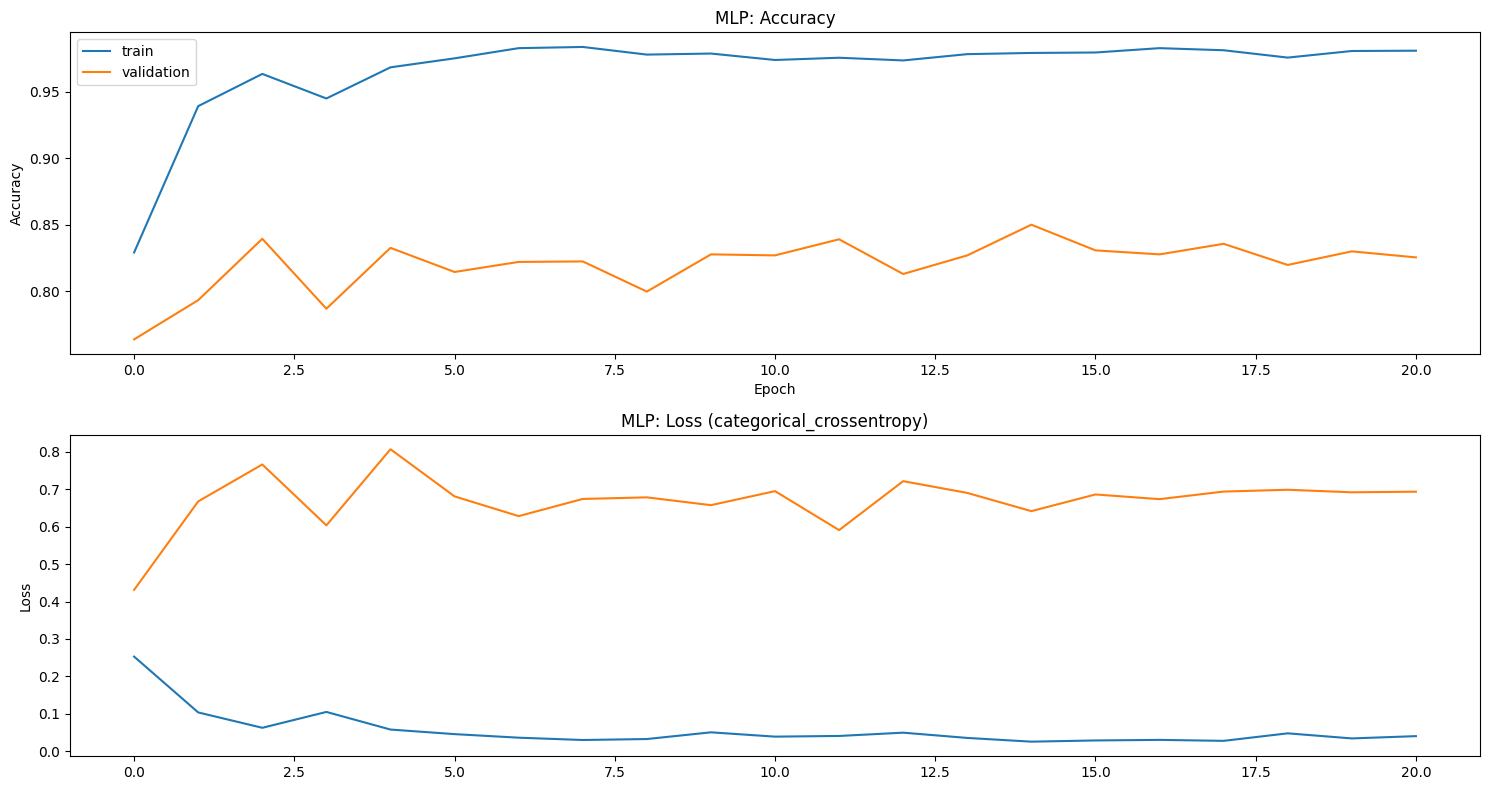

Training model : models/model_GRU_stock_BTC-USD_lookback_24
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: GRU
Epoch 1/200

Epoch 1: val_loss improved from inf to 0.27685, saving model to models\model_GRU_stock_BTC-USD_lookback_24
INFO:tensorflow:Assets written to: models\model_GRU_stock_BTC-USD_lookback_24\assets


INFO:tensorflow:Assets written to: models\model_GRU_stock_BTC-USD_lookback_24\assets


554/554 - 17s - loss: 0.4449 - accuracy: 0.6655 - matthews_correlation_coefficient: 0.4918 - val_loss: 0.2769 - val_accuracy: 0.7852 - val_matthews_correlation_coefficient: 0.6778 - lr: 0.0010 - 17s/epoch - 30ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.27685 to 0.22565, saving model to models\model_GRU_stock_BTC-USD_lookback_24
INFO:tensorflow:Assets written to: models\model_GRU_stock_BTC-USD_lookback_24\assets


INFO:tensorflow:Assets written to: models\model_GRU_stock_BTC-USD_lookback_24\assets


554/554 - 13s - loss: 0.2400 - accuracy: 0.8343 - matthews_correlation_coefficient: 0.7503 - val_loss: 0.2256 - val_accuracy: 0.8318 - val_matthews_correlation_coefficient: 0.7477 - lr: 0.0010 - 13s/epoch - 23ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.22565
554/554 - 8s - loss: 0.1504 - accuracy: 0.9002 - matthews_correlation_coefficient: 0.8498 - val_loss: 0.2820 - val_accuracy: 0.8443 - val_matthews_correlation_coefficient: 0.7665 - lr: 0.0010 - 8s/epoch - 15ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.22565
554/554 - 8s - loss: 0.1138 - accuracy: 0.9282 - matthews_correlation_coefficient: 0.8926 - val_loss: 0.3241 - val_accuracy: 0.8045 - val_matthews_correlation_coefficient: 0.7068 - lr: 0.0010 - 8s/epoch - 15ms/step
Epoch 5/200

Epoch 5: val_loss did not improve from 0.22565
554/554 - 8s - loss: 0.0775 - accuracy: 0.9505 - matthews_correlation_coefficient: 0.9256 - val_loss: 0.4489 - val_accuracy: 0.8348 - val_matthews_correlation_coefficient: 0

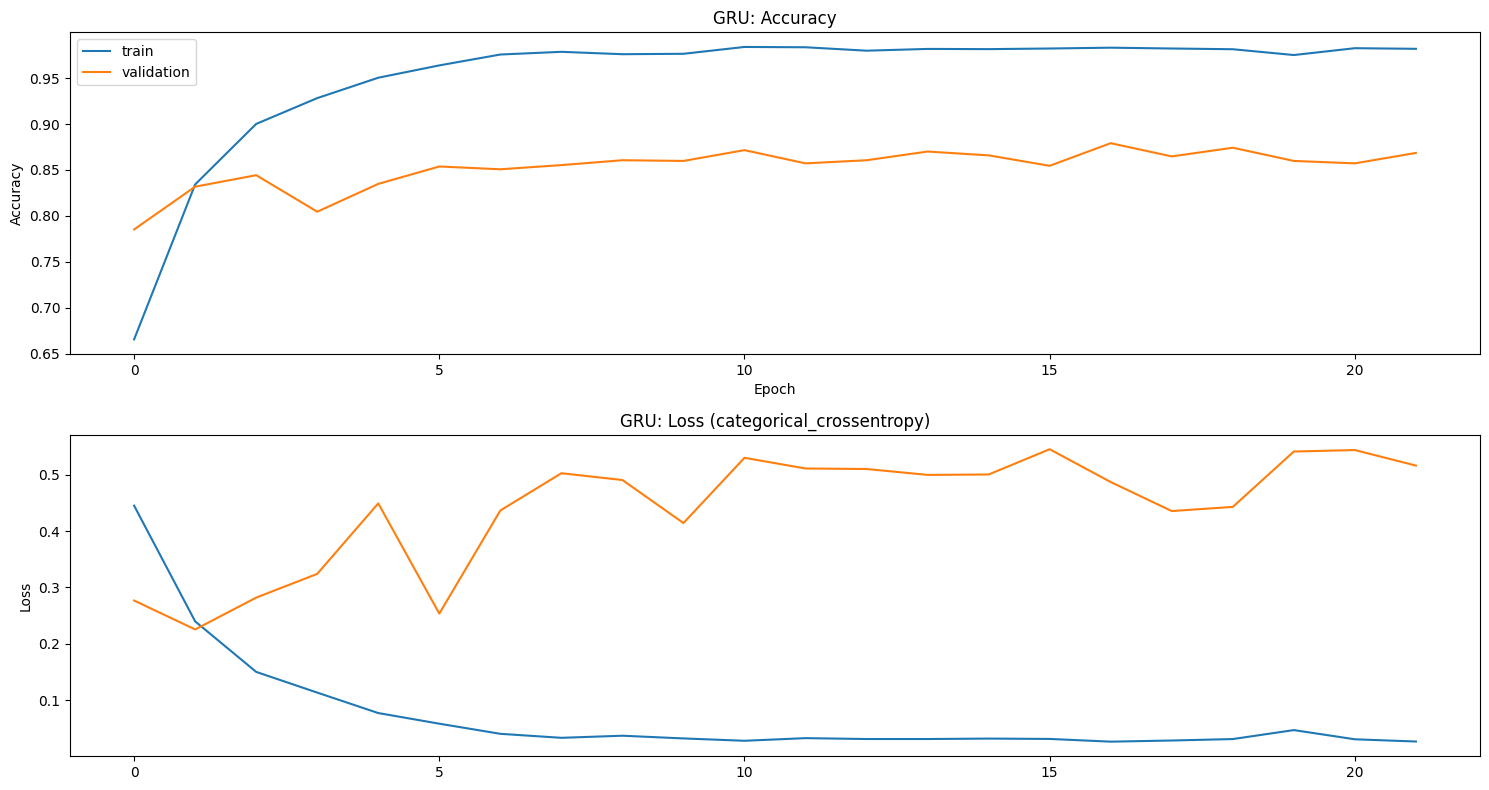

Training model : models/model_CNN_LSTM_MultiHead_stock_BTC-USD_lookback_24
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: CNN_LSTM_MultiHead
Epoch 1/200

Epoch 1: val_loss improved from inf to 0.44648, saving model to models\model_CNN_LSTM_MultiHead_stock_BTC-USD_lookback_24
INFO:tensorflow:Assets written to: models\model_CNN_LSTM_MultiHead_stock_BTC-USD_lookback_24\assets


INFO:tensorflow:Assets written to: models\model_CNN_LSTM_MultiHead_stock_BTC-USD_lookback_24\assets


554/554 - 13s - loss: 0.3950 - accuracy: 0.7412 - matthews_correlation_coefficient: 0.6103 - val_loss: 0.4465 - val_accuracy: 0.6231 - val_matthews_correlation_coefficient: 0.4327 - lr: 0.0010 - 13s/epoch - 24ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.44648 to 0.44020, saving model to models\model_CNN_LSTM_MultiHead_stock_BTC-USD_lookback_24
INFO:tensorflow:Assets written to: models\model_CNN_LSTM_MultiHead_stock_BTC-USD_lookback_24\assets


INFO:tensorflow:Assets written to: models\model_CNN_LSTM_MultiHead_stock_BTC-USD_lookback_24\assets


554/554 - 9s - loss: 0.2644 - accuracy: 0.8237 - matthews_correlation_coefficient: 0.7348 - val_loss: 0.4402 - val_accuracy: 0.6617 - val_matthews_correlation_coefficient: 0.5132 - lr: 0.0010 - 9s/epoch - 16ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.44020 to 0.30773, saving model to models\model_CNN_LSTM_MultiHead_stock_BTC-USD_lookback_24
INFO:tensorflow:Assets written to: models\model_CNN_LSTM_MultiHead_stock_BTC-USD_lookback_24\assets


INFO:tensorflow:Assets written to: models\model_CNN_LSTM_MultiHead_stock_BTC-USD_lookback_24\assets


554/554 - 9s - loss: 0.2014 - accuracy: 0.8645 - matthews_correlation_coefficient: 0.7967 - val_loss: 0.3077 - val_accuracy: 0.7742 - val_matthews_correlation_coefficient: 0.6565 - lr: 0.0010 - 9s/epoch - 15ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.30773
554/554 - 6s - loss: 0.1522 - accuracy: 0.8945 - matthews_correlation_coefficient: 0.8421 - val_loss: 0.3977 - val_accuracy: 0.7629 - val_matthews_correlation_coefficient: 0.6449 - lr: 0.0010 - 6s/epoch - 11ms/step
Epoch 5/200

Epoch 5: val_loss did not improve from 0.30773
554/554 - 6s - loss: 0.1496 - accuracy: 0.9002 - matthews_correlation_coefficient: 0.8501 - val_loss: 0.3486 - val_accuracy: 0.7811 - val_matthews_correlation_coefficient: 0.6716 - lr: 0.0010 - 6s/epoch - 11ms/step
Epoch 6/200

Epoch 6: val_loss did not improve from 0.30773
554/554 - 6s - loss: 0.1405 - accuracy: 0.9040 - matthews_correlation_coefficient: 0.8558 - val_loss: 0.4136 - val_accuracy: 0.7561 - val_matthews_correlation_coefficient: 0.6

INFO:tensorflow:Assets written to: models\model_CNN_LSTM_MultiHead_stock_BTC-USD_lookback_24\assets


554/554 - 9s - loss: 0.1159 - accuracy: 0.9324 - matthews_correlation_coefficient: 0.8985 - val_loss: 0.2615 - val_accuracy: 0.7795 - val_matthews_correlation_coefficient: 0.6693 - lr: 1.0000e-05 - 9s/epoch - 17ms/step
Epoch 12/200

Epoch 12: val_loss did not improve from 0.26151
554/554 - 6s - loss: 0.1085 - accuracy: 0.9311 - matthews_correlation_coefficient: 0.8968 - val_loss: 0.3459 - val_accuracy: 0.7761 - val_matthews_correlation_coefficient: 0.6642 - lr: 1.0000e-05 - 6s/epoch - 11ms/step
Epoch 13/200

Epoch 13: val_loss did not improve from 0.26151
554/554 - 8s - loss: 0.0973 - accuracy: 0.9319 - matthews_correlation_coefficient: 0.8977 - val_loss: 0.3710 - val_accuracy: 0.7795 - val_matthews_correlation_coefficient: 0.6735 - lr: 1.0000e-05 - 8s/epoch - 15ms/step
Epoch 14/200

Epoch 14: val_loss did not improve from 0.26151
554/554 - 8s - loss: 0.1055 - accuracy: 0.9334 - matthews_correlation_coefficient: 0.9001 - val_loss: 0.3691 - val_accuracy: 0.7686 - val_matthews_correlatio

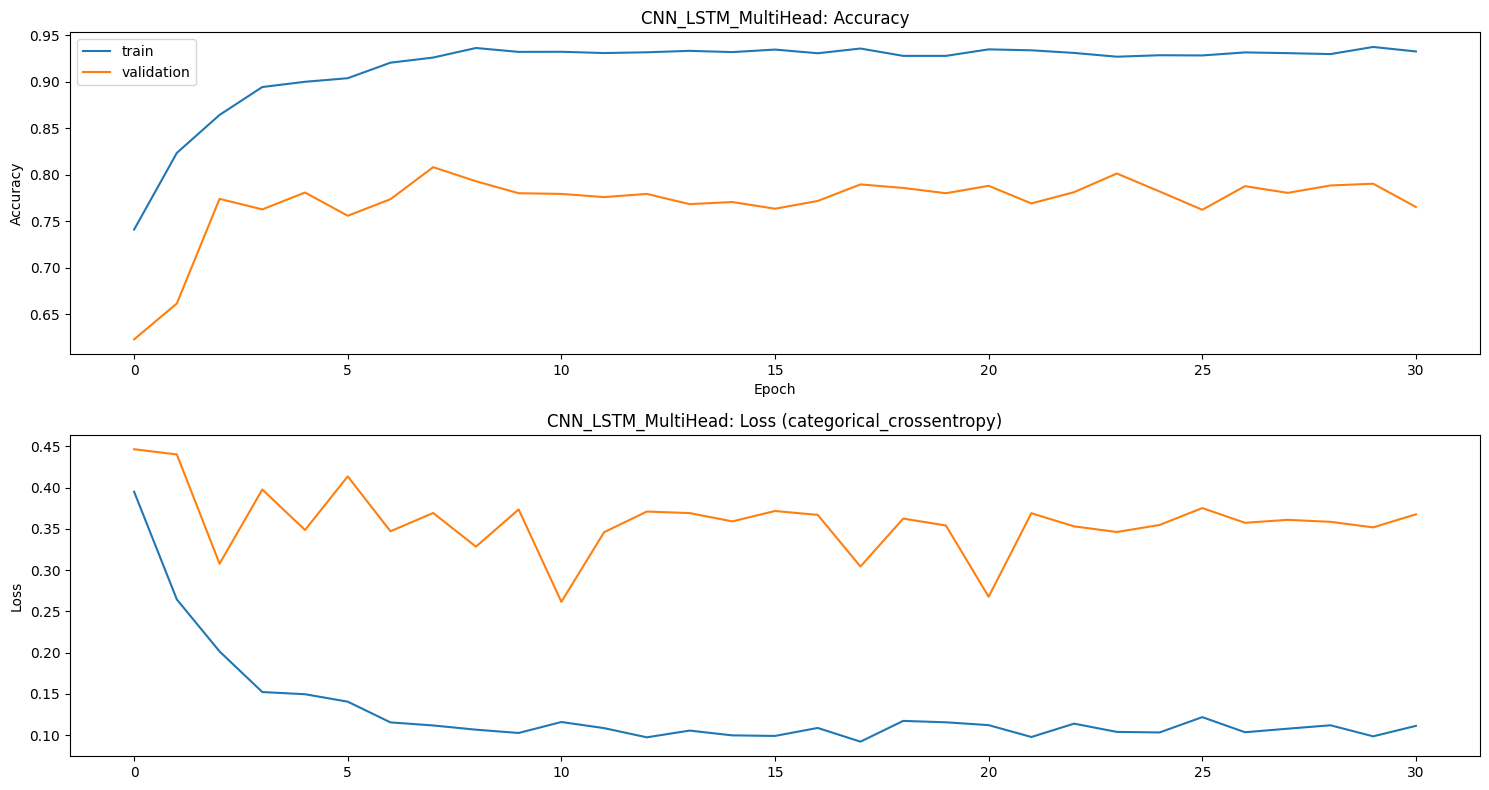

Training model : models/model_CNN_MultiHead_stock_BTC-USD_lookback_24
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: CNN_MultiHead
Epoch 1/200

Epoch 1: val_loss improved from inf to 0.42962, saving model to models\model_CNN_MultiHead_stock_BTC-USD_lookback_24
INFO:tensorflow:Assets written to: models\model_CNN_MultiHead_stock_BTC-USD_lookback_24\assets


INFO:tensorflow:Assets written to: models\model_CNN_MultiHead_stock_BTC-USD_lookback_24\assets


554/554 - 17s - loss: 0.5363 - accuracy: 0.6596 - matthews_correlation_coefficient: 0.4844 - val_loss: 0.4296 - val_accuracy: 0.6602 - val_matthews_correlation_coefficient: 0.4648 - lr: 0.0010 - 17s/epoch - 31ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.42962 to 0.27305, saving model to models\model_CNN_MultiHead_stock_BTC-USD_lookback_24
INFO:tensorflow:Assets written to: models\model_CNN_MultiHead_stock_BTC-USD_lookback_24\assets


INFO:tensorflow:Assets written to: models\model_CNN_MultiHead_stock_BTC-USD_lookback_24\assets


554/554 - 13s - loss: 0.2477 - accuracy: 0.8321 - matthews_correlation_coefficient: 0.7466 - val_loss: 0.2731 - val_accuracy: 0.7481 - val_matthews_correlation_coefficient: 0.6199 - lr: 0.0010 - 13s/epoch - 23ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.27305
554/554 - 8s - loss: 0.1580 - accuracy: 0.8986 - matthews_correlation_coefficient: 0.8470 - val_loss: 0.3142 - val_accuracy: 0.6795 - val_matthews_correlation_coefficient: 0.5319 - lr: 0.0010 - 8s/epoch - 14ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.27305 to 0.22483, saving model to models\model_CNN_MultiHead_stock_BTC-USD_lookback_24
INFO:tensorflow:Assets written to: models\model_CNN_MultiHead_stock_BTC-USD_lookback_24\assets


INFO:tensorflow:Assets written to: models\model_CNN_MultiHead_stock_BTC-USD_lookback_24\assets


554/554 - 12s - loss: 0.1437 - accuracy: 0.9095 - matthews_correlation_coefficient: 0.8640 - val_loss: 0.2248 - val_accuracy: 0.8386 - val_matthews_correlation_coefficient: 0.7532 - lr: 0.0010 - 12s/epoch - 22ms/step
Epoch 5/200

Epoch 5: val_loss did not improve from 0.22483
554/554 - 7s - loss: 0.1117 - accuracy: 0.9363 - matthews_correlation_coefficient: 0.9033 - val_loss: 0.2526 - val_accuracy: 0.8095 - val_matthews_correlation_coefficient: 0.7173 - lr: 0.0010 - 7s/epoch - 13ms/step
Epoch 6/200

Epoch 6: val_loss improved from 0.22483 to 0.18762, saving model to models\model_CNN_MultiHead_stock_BTC-USD_lookback_24
INFO:tensorflow:Assets written to: models\model_CNN_MultiHead_stock_BTC-USD_lookback_24\assets


INFO:tensorflow:Assets written to: models\model_CNN_MultiHead_stock_BTC-USD_lookback_24\assets


554/554 - 12s - loss: 0.1009 - accuracy: 0.9420 - matthews_correlation_coefficient: 0.9127 - val_loss: 0.1876 - val_accuracy: 0.8420 - val_matthews_correlation_coefficient: 0.7665 - lr: 0.0010 - 12s/epoch - 22ms/step
Epoch 7/200

Epoch 7: val_loss did not improve from 0.18762
554/554 - 8s - loss: 0.0527 - accuracy: 0.9690 - matthews_correlation_coefficient: 0.9533 - val_loss: 0.2504 - val_accuracy: 0.8030 - val_matthews_correlation_coefficient: 0.7111 - lr: 0.0010 - 8s/epoch - 14ms/step
Epoch 8/200

Epoch 8: val_loss did not improve from 0.18762
554/554 - 8s - loss: 0.0355 - accuracy: 0.9785 - matthews_correlation_coefficient: 0.9678 - val_loss: 0.2374 - val_accuracy: 0.8553 - val_matthews_correlation_coefficient: 0.7783 - lr: 0.0010 - 8s/epoch - 14ms/step
Epoch 9/200

Epoch 9: val_loss improved from 0.18762 to 0.17359, saving model to models\model_CNN_MultiHead_stock_BTC-USD_lookback_24
INFO:tensorflow:Assets written to: models\model_CNN_MultiHead_stock_BTC-USD_lookback_24\assets


INFO:tensorflow:Assets written to: models\model_CNN_MultiHead_stock_BTC-USD_lookback_24\assets


554/554 - 12s - loss: 0.0708 - accuracy: 0.9577 - matthews_correlation_coefficient: 0.9365 - val_loss: 0.1736 - val_accuracy: 0.8655 - val_matthews_correlation_coefficient: 0.7983 - lr: 0.0010 - 12s/epoch - 21ms/step
Epoch 10/200

Epoch 10: val_loss did not improve from 0.17359
554/554 - 7s - loss: 0.0609 - accuracy: 0.9646 - matthews_correlation_coefficient: 0.9469 - val_loss: 0.2105 - val_accuracy: 0.8269 - val_matthews_correlation_coefficient: 0.7403 - lr: 0.0010 - 7s/epoch - 13ms/step
Epoch 11/200

Epoch 11: val_loss did not improve from 0.17359
554/554 - 8s - loss: 0.0638 - accuracy: 0.9636 - matthews_correlation_coefficient: 0.9453 - val_loss: 0.3054 - val_accuracy: 0.8201 - val_matthews_correlation_coefficient: 0.7252 - lr: 0.0010 - 8s/epoch - 14ms/step
Epoch 12/200

Epoch 12: val_loss did not improve from 0.17359
554/554 - 8s - loss: 0.0687 - accuracy: 0.9602 - matthews_correlation_coefficient: 0.9401 - val_loss: 0.2809 - val_accuracy: 0.8152 - val_matthews_correlation_coeffici

INFO:tensorflow:Assets written to: models\model_CNN_MultiHead_stock_BTC-USD_lookback_24\assets


554/554 - 16s - loss: 0.0510 - accuracy: 0.9718 - matthews_correlation_coefficient: 0.9578 - val_loss: 0.1605 - val_accuracy: 0.8841 - val_matthews_correlation_coefficient: 0.8305 - lr: 0.0010 - 16s/epoch - 28ms/step
Epoch 15/200

Epoch 15: val_loss did not improve from 0.16054
554/554 - 8s - loss: 0.0297 - accuracy: 0.9818 - matthews_correlation_coefficient: 0.9727 - val_loss: 0.2000 - val_accuracy: 0.8909 - val_matthews_correlation_coefficient: 0.8317 - lr: 0.0010 - 8s/epoch - 14ms/step
Epoch 16/200

Epoch 16: val_loss did not improve from 0.16054
554/554 - 7s - loss: 0.0307 - accuracy: 0.9836 - matthews_correlation_coefficient: 0.9754 - val_loss: 0.1935 - val_accuracy: 0.8557 - val_matthews_correlation_coefficient: 0.7832 - lr: 0.0010 - 7s/epoch - 13ms/step
Epoch 17/200

Epoch 17: val_loss did not improve from 0.16054
554/554 - 8s - loss: 0.0147 - accuracy: 0.9914 - matthews_correlation_coefficient: 0.9868 - val_loss: 0.2146 - val_accuracy: 0.8773 - val_matthews_correlation_coeffici

INFO:tensorflow:Assets written to: models\model_CNN_MultiHead_stock_BTC-USD_lookback_24\assets


554/554 - 12s - loss: 0.0070 - accuracy: 0.9965 - matthews_correlation_coefficient: 0.9948 - val_loss: 0.1581 - val_accuracy: 0.9027 - val_matthews_correlation_coefficient: 0.8540 - lr: 0.0010 - 12s/epoch - 22ms/step
Epoch 20/200

Epoch 20: val_loss did not improve from 0.15815
554/554 - 8s - loss: 0.0075 - accuracy: 0.9950 - matthews_correlation_coefficient: 0.9925 - val_loss: 0.1855 - val_accuracy: 0.9034 - val_matthews_correlation_coefficient: 0.8551 - lr: 0.0010 - 8s/epoch - 14ms/step
Epoch 21/200

Epoch 21: val_loss did not improve from 0.15815
554/554 - 8s - loss: 0.0058 - accuracy: 0.9975 - matthews_correlation_coefficient: 0.9964 - val_loss: 0.2505 - val_accuracy: 0.8765 - val_matthews_correlation_coefficient: 0.8190 - lr: 0.0010 - 8s/epoch - 14ms/step
Epoch 22/200

Epoch 22: val_loss did not improve from 0.15815
554/554 - 7s - loss: 0.0100 - accuracy: 0.9949 - matthews_correlation_coefficient: 0.9924 - val_loss: 0.2055 - val_accuracy: 0.9117 - val_matthews_correlation_coeffici

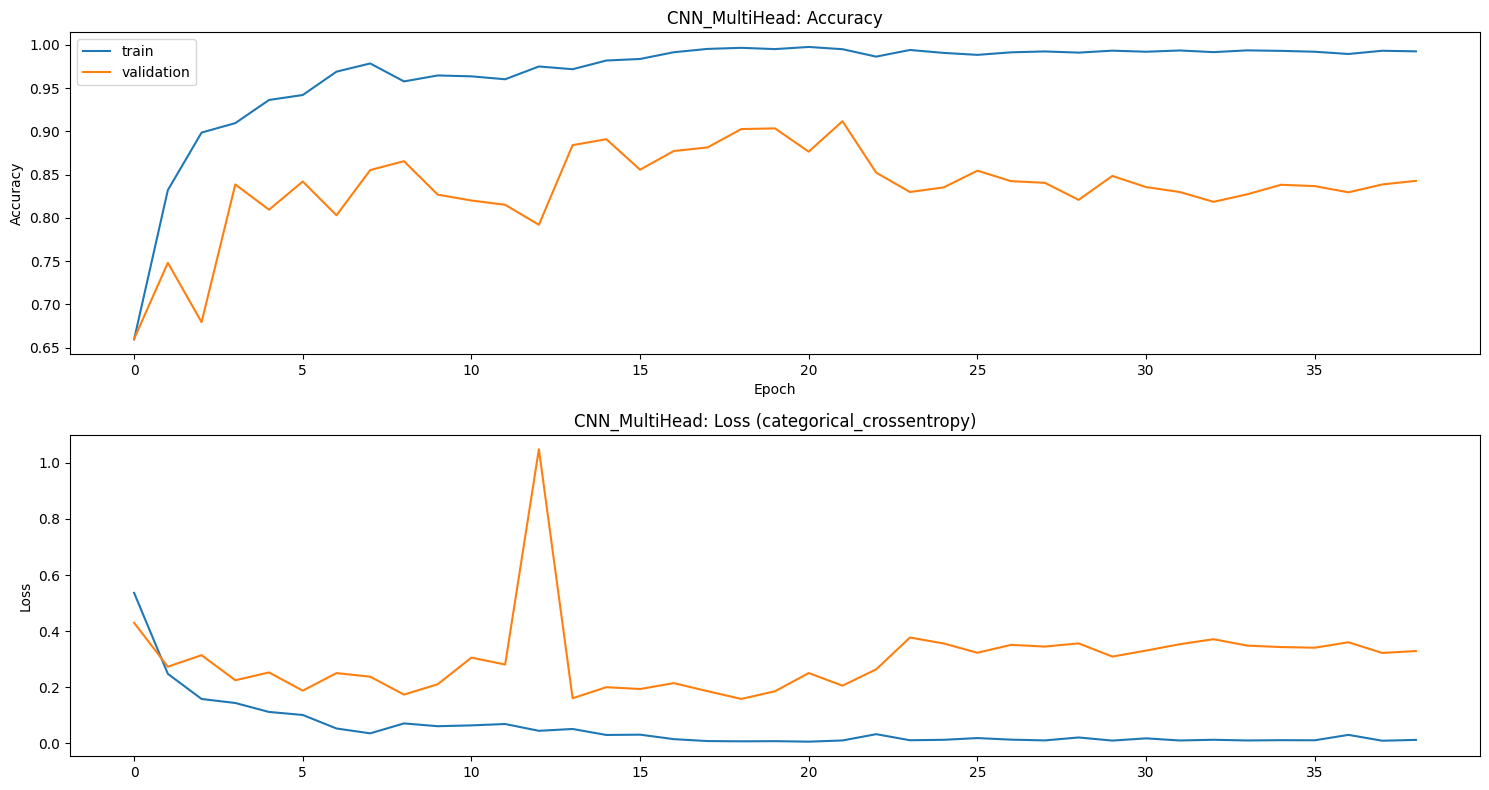

Training model : models/model_LSTM_stock_BTC-USD_lookback_24
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: LSTM
Epoch 1/200

Epoch 1: val_loss improved from inf to 0.49452, saving model to models\model_LSTM_stock_BTC-USD_lookback_24
INFO:tensorflow:Assets written to: models\model_LSTM_stock_BTC-USD_lookback_24\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_BTC-USD_lookback_24\assets


554/554 - 27s - loss: 0.7875 - accuracy: 0.4920 - matthews_correlation_coefficient: 0.2017 - val_loss: 0.4945 - val_accuracy: 0.6121 - val_matthews_correlation_coefficient: 0.3836 - lr: 0.0010 - 27s/epoch - 49ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.49452
554/554 - 14s - loss: 0.4130 - accuracy: 0.7252 - matthews_correlation_coefficient: 0.5707 - val_loss: 2.1608 - val_accuracy: 0.7083 - val_matthews_correlation_coefficient: 0.5625 - lr: 0.0010 - 14s/epoch - 25ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.49452 to 0.39636, saving model to models\model_LSTM_stock_BTC-USD_lookback_24
INFO:tensorflow:Assets written to: models\model_LSTM_stock_BTC-USD_lookback_24\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_BTC-USD_lookback_24\assets


554/554 - 22s - loss: 0.4075 - accuracy: 0.7439 - matthews_correlation_coefficient: 0.6081 - val_loss: 0.3964 - val_accuracy: 0.6314 - val_matthews_correlation_coefficient: 0.4510 - lr: 0.0010 - 22s/epoch - 39ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.39636 to 0.34103, saving model to models\model_LSTM_stock_BTC-USD_lookback_24
INFO:tensorflow:Assets written to: models\model_LSTM_stock_BTC-USD_lookback_24\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_BTC-USD_lookback_24\assets


554/554 - 21s - loss: 0.3238 - accuracy: 0.7902 - matthews_correlation_coefficient: 0.6826 - val_loss: 0.3410 - val_accuracy: 0.6928 - val_matthews_correlation_coefficient: 0.5392 - lr: 0.0010 - 21s/epoch - 38ms/step
Epoch 5/200

Epoch 5: val_loss did not improve from 0.34103
554/554 - 14s - loss: 0.2453 - accuracy: 0.8345 - matthews_correlation_coefficient: 0.7499 - val_loss: 0.4231 - val_accuracy: 0.7186 - val_matthews_correlation_coefficient: 0.5819 - lr: 0.0010 - 14s/epoch - 24ms/step
Epoch 6/200

Epoch 6: val_loss improved from 0.34103 to 0.32793, saving model to models\model_LSTM_stock_BTC-USD_lookback_24
INFO:tensorflow:Assets written to: models\model_LSTM_stock_BTC-USD_lookback_24\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_BTC-USD_lookback_24\assets


554/554 - 22s - loss: 0.2509 - accuracy: 0.8236 - matthews_correlation_coefficient: 0.7343 - val_loss: 0.3279 - val_accuracy: 0.7106 - val_matthews_correlation_coefficient: 0.5697 - lr: 0.0010 - 22s/epoch - 40ms/step
Epoch 7/200

Epoch 7: val_loss did not improve from 0.32793
554/554 - 13s - loss: 0.2038 - accuracy: 0.8619 - matthews_correlation_coefficient: 0.7926 - val_loss: 0.5973 - val_accuracy: 0.6356 - val_matthews_correlation_coefficient: 0.4534 - lr: 0.0010 - 13s/epoch - 24ms/step
Epoch 8/200

Epoch 8: val_loss improved from 0.32793 to 0.29597, saving model to models\model_LSTM_stock_BTC-USD_lookback_24
INFO:tensorflow:Assets written to: models\model_LSTM_stock_BTC-USD_lookback_24\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_BTC-USD_lookback_24\assets


554/554 - 22s - loss: 0.2071 - accuracy: 0.8667 - matthews_correlation_coefficient: 0.7984 - val_loss: 0.2960 - val_accuracy: 0.7917 - val_matthews_correlation_coefficient: 0.6875 - lr: 0.0010 - 22s/epoch - 39ms/step
Epoch 9/200

Epoch 9: val_loss did not improve from 0.29597
554/554 - 14s - loss: 0.2087 - accuracy: 0.8628 - matthews_correlation_coefficient: 0.7943 - val_loss: 0.5617 - val_accuracy: 0.7705 - val_matthews_correlation_coefficient: 0.6506 - lr: 0.0010 - 14s/epoch - 25ms/step
Epoch 10/200

Epoch 10: val_loss did not improve from 0.29597
554/554 - 14s - loss: 0.2097 - accuracy: 0.8528 - matthews_correlation_coefficient: 0.7786 - val_loss: 0.3580 - val_accuracy: 0.7905 - val_matthews_correlation_coefficient: 0.6858 - lr: 0.0010 - 14s/epoch - 25ms/step
Epoch 11/200

Epoch 11: val_loss improved from 0.29597 to 0.23680, saving model to models\model_LSTM_stock_BTC-USD_lookback_24
INFO:tensorflow:Assets written to: models\model_LSTM_stock_BTC-USD_lookback_24\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_BTC-USD_lookback_24\assets


554/554 - 22s - loss: 0.1865 - accuracy: 0.8771 - matthews_correlation_coefficient: 0.8157 - val_loss: 0.2368 - val_accuracy: 0.8148 - val_matthews_correlation_coefficient: 0.7222 - lr: 0.0010 - 22s/epoch - 39ms/step
Epoch 12/200

Epoch 12: val_loss did not improve from 0.23680
554/554 - 13s - loss: 0.1626 - accuracy: 0.8873 - matthews_correlation_coefficient: 0.8315 - val_loss: 0.4643 - val_accuracy: 0.8345 - val_matthews_correlation_coefficient: 0.7517 - lr: 0.0010 - 13s/epoch - 24ms/step
Epoch 13/200

Epoch 13: val_loss did not improve from 0.23680
554/554 - 14s - loss: 0.1656 - accuracy: 0.8831 - matthews_correlation_coefficient: 0.8242 - val_loss: 0.2569 - val_accuracy: 0.7871 - val_matthews_correlation_coefficient: 0.6807 - lr: 0.0010 - 14s/epoch - 25ms/step
Epoch 14/200

Epoch 14: val_loss did not improve from 0.23680
554/554 - 14s - loss: 0.1625 - accuracy: 0.8889 - matthews_correlation_coefficient: 0.8331 - val_loss: 0.3787 - val_accuracy: 0.8352 - val_matthews_correlation_coe

INFO:tensorflow:Assets written to: models\model_LSTM_stock_BTC-USD_lookback_24\assets


554/554 - 21s - loss: 0.1355 - accuracy: 0.9014 - matthews_correlation_coefficient: 0.8516 - val_loss: 0.2152 - val_accuracy: 0.8303 - val_matthews_correlation_coefficient: 0.7455 - lr: 1.0000e-05 - 21s/epoch - 38ms/step
Epoch 20/200

Epoch 20: val_loss did not improve from 0.21524
554/554 - 14s - loss: 0.1353 - accuracy: 0.9024 - matthews_correlation_coefficient: 0.8532 - val_loss: 0.3212 - val_accuracy: 0.8307 - val_matthews_correlation_coefficient: 0.7460 - lr: 1.0000e-05 - 14s/epoch - 25ms/step
Epoch 21/200

Epoch 21: val_loss did not improve from 0.21524
554/554 - 15s - loss: 0.1455 - accuracy: 0.9025 - matthews_correlation_coefficient: 0.8532 - val_loss: 0.3112 - val_accuracy: 0.8314 - val_matthews_correlation_coefficient: 0.7472 - lr: 1.0000e-05 - 15s/epoch - 27ms/step
Epoch 22/200

Epoch 22: val_loss did not improve from 0.21524
554/554 - 14s - loss: 0.1344 - accuracy: 0.9061 - matthews_correlation_coefficient: 0.8589 - val_loss: 0.3214 - val_accuracy: 0.8288 - val_matthews_cor

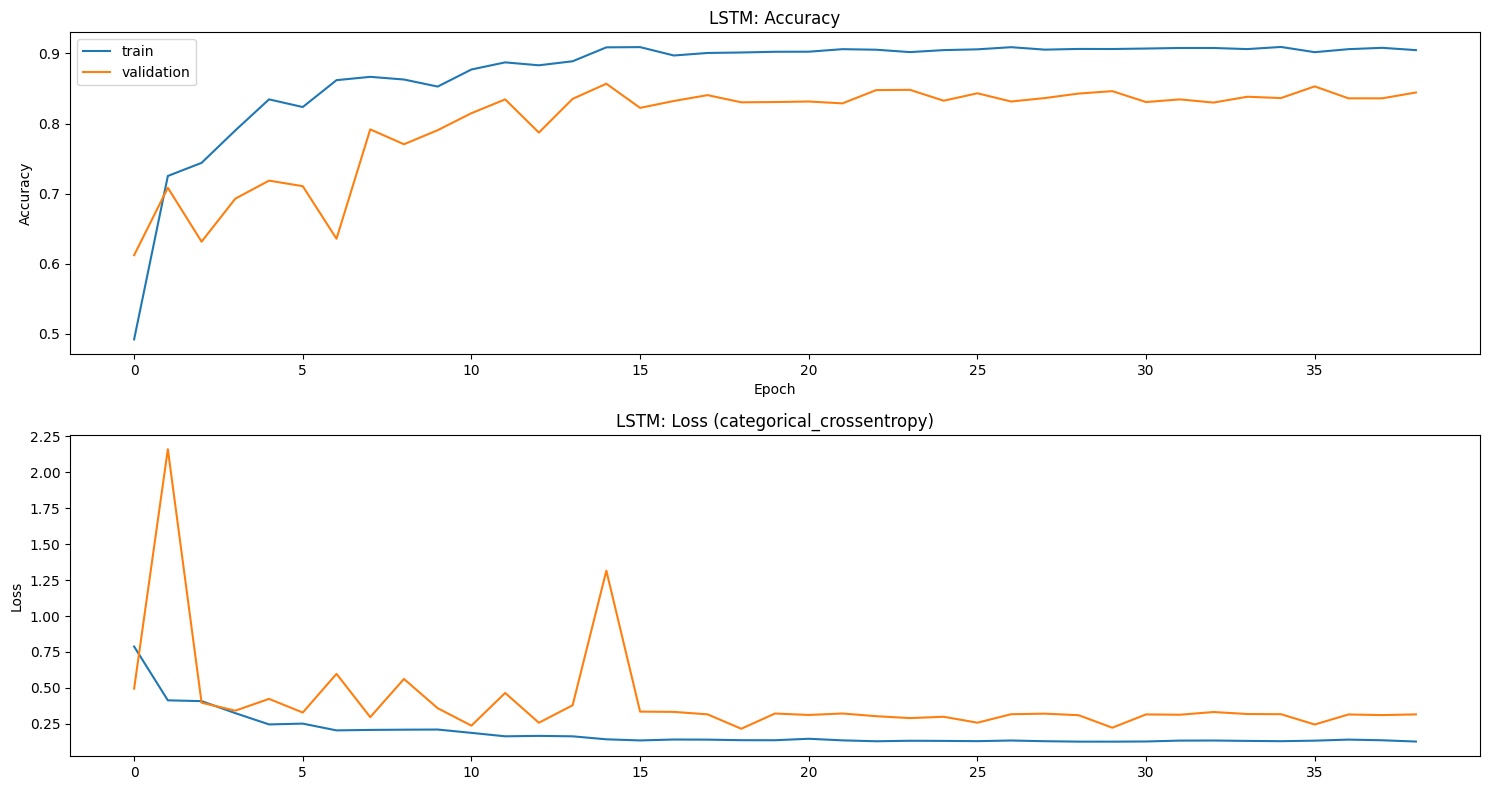

Training model : models/model_LSTM_AT_stock_BTC-USD_lookback_24
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: LSTM_AT
Epoch 1/200

Epoch 1: val_loss improved from inf to 3.09300, saving model to models\model_LSTM_AT_stock_BTC-USD_lookback_24
INFO:tensorflow:Assets written to: models\model_LSTM_AT_stock_BTC-USD_lookback_24\assets


INFO:tensorflow:Assets written to: models\model_LSTM_AT_stock_BTC-USD_lookback_24\assets


554/554 - 26s - loss: 3.6502 - accuracy: 0.4012 - matthews_correlation_coefficient: 0.1016 - val_loss: 3.0930 - val_accuracy: 0.4629 - val_matthews_correlation_coefficient: 0.1943 - lr: 0.0010 - 26s/epoch - 47ms/step
Epoch 2/200

Epoch 2: val_loss improved from 3.09300 to 2.40274, saving model to models\model_LSTM_AT_stock_BTC-USD_lookback_24
INFO:tensorflow:Assets written to: models\model_LSTM_AT_stock_BTC-USD_lookback_24\assets


INFO:tensorflow:Assets written to: models\model_LSTM_AT_stock_BTC-USD_lookback_24\assets


554/554 - 18s - loss: 1.8865 - accuracy: 0.6330 - matthews_correlation_coefficient: 0.4497 - val_loss: 2.4027 - val_accuracy: 0.6792 - val_matthews_correlation_coefficient: 0.5188 - lr: 0.0010 - 18s/epoch - 33ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 2.40274
554/554 - 11s - loss: 1.2354 - accuracy: 0.7342 - matthews_correlation_coefficient: 0.6011 - val_loss: 2.4829 - val_accuracy: 0.5913 - val_matthews_correlation_coefficient: 0.3869 - lr: 0.0010 - 11s/epoch - 19ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 2.40274
554/554 - 11s - loss: 0.8950 - accuracy: 0.7843 - matthews_correlation_coefficient: 0.6763 - val_loss: 2.7535 - val_accuracy: 0.8038 - val_matthews_correlation_coefficient: 0.7057 - lr: 0.0010 - 11s/epoch - 19ms/step
Epoch 5/200

Epoch 5: val_loss did not improve from 2.40274
554/554 - 11s - loss: 0.6151 - accuracy: 0.8329 - matthews_correlation_coefficient: 0.7493 - val_loss: 3.7983 - val_accuracy: 0.7973 - val_matthews_correlation_coefficie

INFO:tensorflow:Assets written to: models\model_LSTM_AT_stock_BTC-USD_lookback_24\assets


554/554 - 19s - loss: 0.3891 - accuracy: 0.8696 - matthews_correlation_coefficient: 0.8045 - val_loss: 2.2386 - val_accuracy: 0.7405 - val_matthews_correlation_coefficient: 0.6108 - lr: 0.0010 - 19s/epoch - 34ms/step
Epoch 8/200

Epoch 8: val_loss did not improve from 2.23862
554/554 - 10s - loss: 0.4043 - accuracy: 0.8688 - matthews_correlation_coefficient: 0.8033 - val_loss: 2.7900 - val_accuracy: 0.8144 - val_matthews_correlation_coefficient: 0.7216 - lr: 0.0010 - 10s/epoch - 19ms/step
Epoch 9/200

Epoch 9: val_loss did not improve from 2.23862
554/554 - 11s - loss: 0.3278 - accuracy: 0.8797 - matthews_correlation_coefficient: 0.8197 - val_loss: 2.8916 - val_accuracy: 0.8326 - val_matthews_correlation_coefficient: 0.7489 - lr: 0.0010 - 11s/epoch - 19ms/step
Epoch 10/200

Epoch 10: val_loss did not improve from 2.23862
554/554 - 10s - loss: 0.2576 - accuracy: 0.8956 - matthews_correlation_coefficient: 0.8435 - val_loss: 3.4751 - val_accuracy: 0.8239 - val_matthews_correlation_coeffic

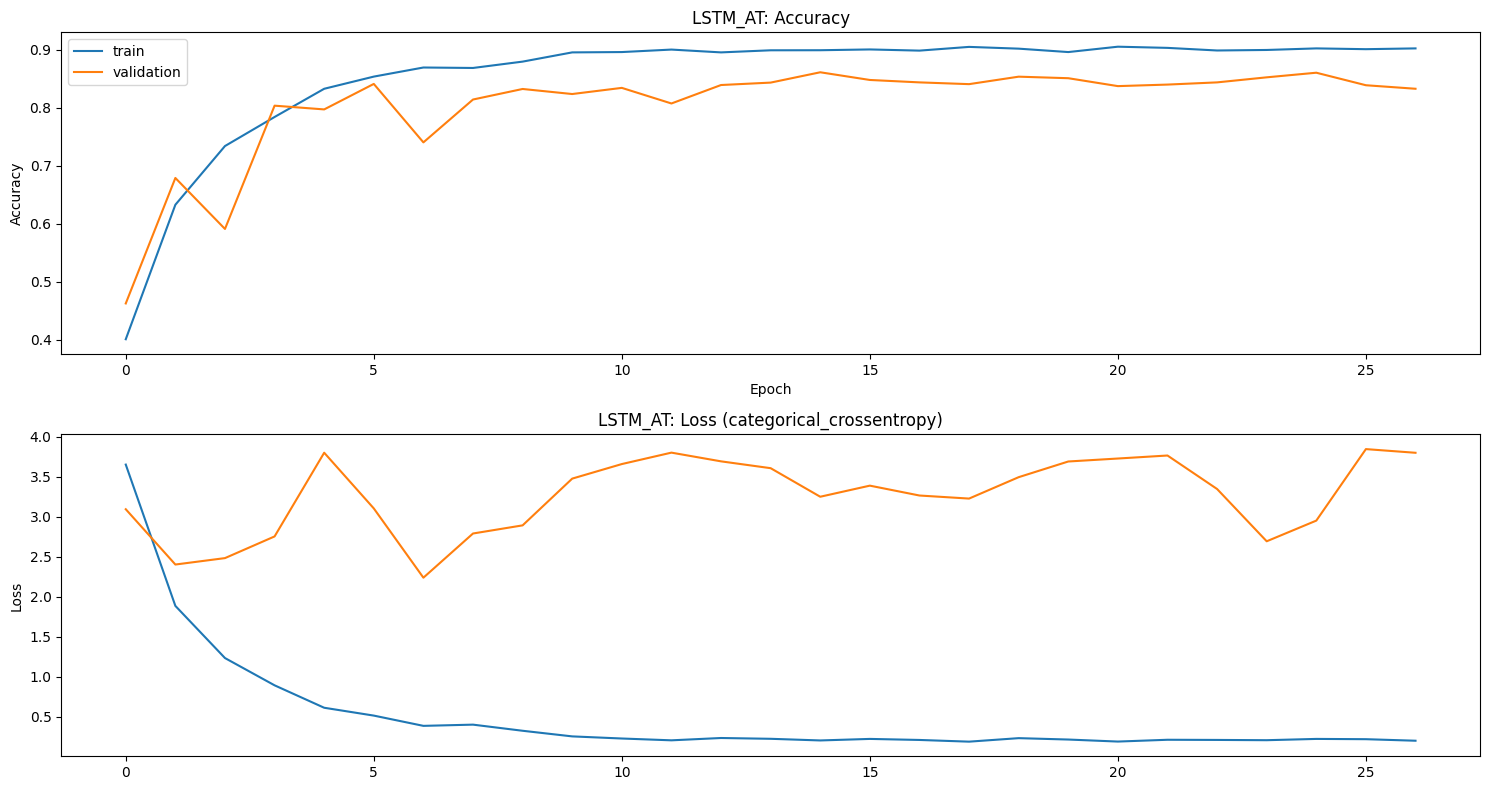

In [59]:
list_of_models=[model_MLP, model_GRU, model_CNN_LSTM, model_CNN_MultiHead, model_LSTM, model_LSTM_AT]
#list_of_models=[model_LSTM, model_LSTM_AT, model_GRU ]
#list_of_models=[model_LSTM_AT]
#list_of_models=[model_MLP, model_CNN_LSTM, model_LSTM_AT]
#list_of_models=[model_CNN_MultiHead]

for model in list_of_models:  
    optimizer = get_optimizer()
    csvLogger, model_checkpoint_callback  = checkpoints(model._name)
    model.compile(loss=[loss], optimizer=optimizer, metrics=['accuracy',matthews_correlation_coefficient])

    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print(f'Initing train fo model: {model._name}')
    #history=model.fit( X_data_gen_train, validation_data=X_data_gen_val, epochs=200, batch_size=32, shuffle=False, validation_split=0.3, callbacks=[EarlyStopping, reduceLr, model_checkpoint_callback,csvLogger])
    #history=model.fit_generator( X_data_gen_train, epochs=200, callbacks=[EarlyStopping, reduceLr, model_checkpoint_callback,csvLogger], validation_data=X_data_gen_val, verbose=0)
    #history=model.fit( X_data_gen_train.features, X_data_gen_train.y_classification, epochs=200, verbose=1)
    history = model.fit(
        X_data_gen_train,
        epochs=200,
        callbacks=[EarlyStopping, reduceLr, model_checkpoint_callback, csvLogger],
        validation_data=X_data_gen_val,
        #shuffle=True,
        verbose=2
    )
    # Assuming history_metric, history_metric_val, history are defined elsewhere

    fig, axes = plt.subplots(2, 1, figsize=(15, 8))  # Create subplots programmatically

    # Plot accuracy, sharing x-axis with NRMSE
    axes[0].plot(history.history['accuracy'])
    axes[0].plot(history.history['val_accuracy'])
    axes[0].set_title(f'{model._name}: Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')  # Shared x-axis label
    axes[0].legend(['train', 'validation'], loc='upper left')

    # Plot loss
    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    axes[1].set_title(f'{model._name}: Loss (categorical_crossentropy)')
    axes[1].set_ylabel('Loss')

    # Adjust spacing and margins (optional)
    plt.subplots_adjust(left=0.1, bottom=0.15, right=0.9, top=0.9, wspace=0.2)

    # Fine-tune spacing (optional)
    plt.tight_layout()

    plt.show()

    #history=model.fit( x=X_train, y=y_train, epochs=200, batch_size=256, shuffle=True, validation_split=0.1, callbacks=[EarlyStopping,model_checkpoint_callback, reduceLr])

### Validation

#### Load the trained models


In [60]:
trained_best_models={}
for model in list_of_models:
    print(model.name)
    checkpoint_filepath =f'models/model_{model._name}_stock_{ticker}_lookback_{lookback}'
    trained_best_models[f'{model._name}']=tf.keras.models.load_model(
        checkpoint_filepath, 
        custom_objects={'loss': weighted_categorical_crossentropy_loss, 'matthews_correlation_coefficient': matthews_correlation_coefficient})

MLP



GRU
CNN_LSTM_MultiHead
CNN_MultiHead
LSTM
LSTM_AT


#### Using the validation Dataset

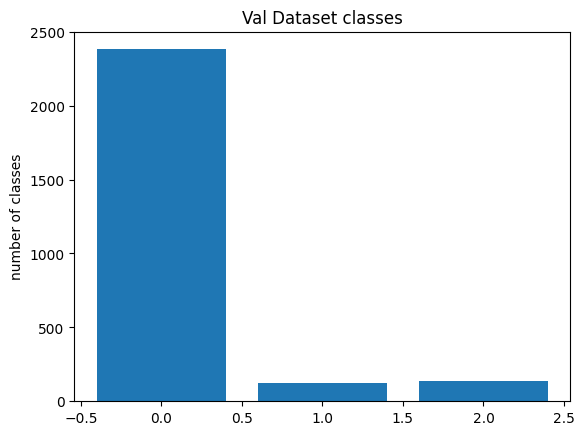

In [61]:
Y_val_categorical=np.argmax(X_data_gen_val.y_classification,axis=1)
classes, counts=np.unique(Y_val_categorical,return_counts=True) 

fig, ax = plt.subplots()
plt.bar(classes,counts)
ax.set_ylabel('number of classes')
ax.set_title('Val Dataset classes')
plt.show()

In [62]:
X_data_gen_val = FeaturesDataGenerator(df[df['Date'].isin(T_val)].iloc[:,1:], lookback = lookback, pred_days = pred_days,  buy_sell_threshold=buy_sell_threshold, shuffle= False, batch_size=batch_size, selected_features = features_indicators, data_augmentation=False)


self.pred_days 72


d:\Projetos_python\Time_Series_Forecast\acoes\Processing\ProcessingPipeline.py:294: RuntimeWarning:

invalid value encountered in divide



input data shape (2644, 24, 22)
output data shape (2644, 3)


In [63]:
# get metrics on validation dataset
idxs=np.where(np.argmax(X_data_gen_val.y_classification, axis=1)> -1 )[0]

x_data = np.zeros_like(X_data_gen_val.features)
for i in range(X_data_gen_val.features.shape[0]):
    x_data[i] = X_data_gen_val.norm_minmax(
        X_data_gen_val.features[i],
        minimum=0,
        maximum=1,
        axis=None
    )

import utils
for model_name in trained_best_models:

    label_pred = trained_best_models[model_name].predict(x_data)
    print(model_name,' classification Accuracy',
                    utils.f1_score(np.argmax(X_data_gen_val.y_classification,axis=1),
                    np.argmax(label_pred,axis=1), average='micro'))
#utils.model_metrics(['subida','Descida'], y_test, y_pred, Get_metrics=False)

#utils.plot_confusion_matrix(['subida','Descida'], y_test, y_pred)

83/83 [==============================] - 1s 3ms/step
MLP  classification Accuracy 0.7431921331316188
83/83 [==============================] - 1s 6ms/step
GRU  classification Accuracy 0.41565809379727686
83/83 [==============================] - 1s 4ms/step
CNN_LSTM_MultiHead  classification Accuracy 0.6887291981845688
83/83 [==============================] - 1s 5ms/step
CNN_MultiHead  classification Accuracy 0.12481089258698941
83/83 [==============================] - 2s 10ms/step
LSTM  classification Accuracy 0.7083963691376702
83/83 [==============================] - 2s 8ms/step
LSTM_AT  classification Accuracy 0.583963691376702


In [64]:
np.argmax(X_data_gen_val.y_classification[idxs],axis=1).shape

(2644,)

Model name: CNN_MultiHead
83/83 [==============================] - 1s 6ms/step
CNN_MultiHead  classification Accuracy 0.8869137670196672


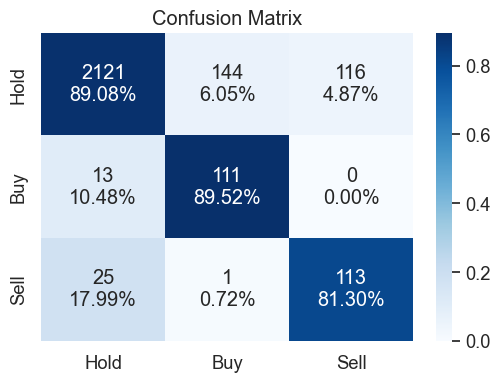

In [92]:
model_name = "CNN_MultiHead"  
print('Model name:',model_name)
x_data= np.apply_along_axis(lambda row: X_data_gen_val.norm_minmax(row, minimum=-1, maximum=1, axis=0), axis=1, arr=X_data_gen_val.features[idxs])

label_pred = trained_best_models[model_name].predict(x_data)
print(model_name,' classification Accuracy',
                utils.f1_score(np.argmax(X_data_gen_val.y_classification[idxs],axis=1),
                np.argmax(label_pred,axis=1),average="micro"))

cf_matrix = utils.confusion_matrix(np.argmax(X_data_gen_val.y_classification[idxs],axis=1),np.argmax(label_pred,axis=1))
 
try:
    utils.plot_confusion_matrix(gesture_list= ['Hold','Buy','Sell'], cf_matrix=cf_matrix)
except:
    print(cf_matrix)

### Using test dataset

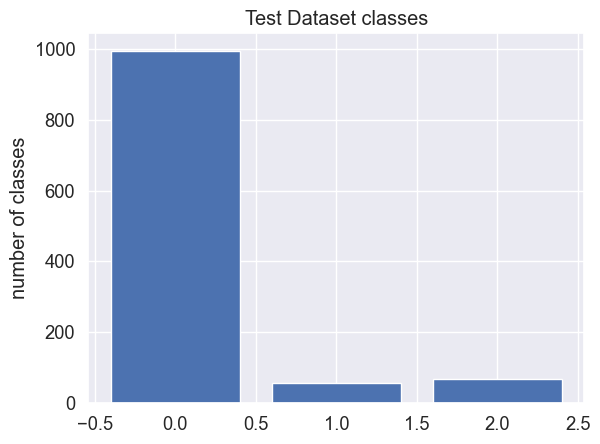

In [66]:
Y_train_categorical=np.argmax(X_data_gen_test.y_classification,axis=1)
classes, counts=np.unique(Y_train_categorical,return_counts=True) 

fig, ax = plt.subplots()
plt.bar(classes,counts)
ax.set_ylabel('number of classes')
ax.set_title('Test Dataset classes')
plt.show()

In [67]:
X_data_gen_test = FeaturesDataGenerator(df[df['Date'].isin(T_test)].iloc[:,1:], lookback = lookback, pred_days = pred_days, shuffle= False, batch_size=1, selected_features = features_indicators, data_augmentation=False)
test_data=[]
targets=[]
for X,y in X_data_gen_test:
    #train_data+=[scaler.transform(np.array(X).reshape(-1,1))]
    test_data+=[np.array(X)]
    targets+=[np.argmax(y)]
targets = np.stack(targets)
test_data = np.vstack(test_data)

self.pred_days 72


d:\Projetos_python\Time_Series_Forecast\acoes\Processing\ProcessingPipeline.py:294: RuntimeWarning:

invalid value encountered in divide



input data shape (1120, 24, 22)
output data shape (1120, 3)


In [68]:
label_pred.shape

(2644, 3)

In [69]:
# get metrics for all deep learning models 
import utils
for model_name in trained_best_models:
    label_pred = trained_best_models[model_name].predict(test_data)
    print(f'{model_name} metrics:')
    utils.model_average_std_metrics(targets, np.argmax(label_pred,axis=1), Get_metrics= True,  Verbose=True) ;
    print('------------------------------------------------')

35/35 [==============================] - 0s 3ms/step
MLP metrics:
Precision Score: 0.5993±0.2627
Recall Score: 0.7118±0.1228
F1-Score: 0.6353±0.206
Accuracy: 0.7118±0.1228
------------------------------------------------
35/35 [==============================] - 0s 6ms/step
GRU metrics:
Precision Score: 0.5592±0.2952
Recall Score: 0.8325±0.0706
F1-Score: 0.6225±0.183
Accuracy: 0.8325±0.0706
------------------------------------------------
35/35 [==============================] - 0s 4ms/step
CNN_LSTM_MultiHead metrics:
Precision Score: 0.5584±0.3027
Recall Score: 0.8059±0.0797
F1-Score: 0.6062±0.1966
Accuracy: 0.8059±0.0797
------------------------------------------------
35/35 [==============================] - 0s 6ms/step
CNN_MultiHead metrics:
Precision Score: 0.6222±0.2567
Recall Score: 0.8453±0.026
F1-Score: 0.6903±0.1666
Accuracy: 0.8453±0.026
------------------------------------------------
35/35 [==============================] - 0s 11ms/step
LSTM metrics:
Precision Score: 0.554±

Model name: CNN_MultiHead
35/35 [==============================] - 0s 5ms/step
CNN_MultiHead  classification Accuracy 0.6903148510769865


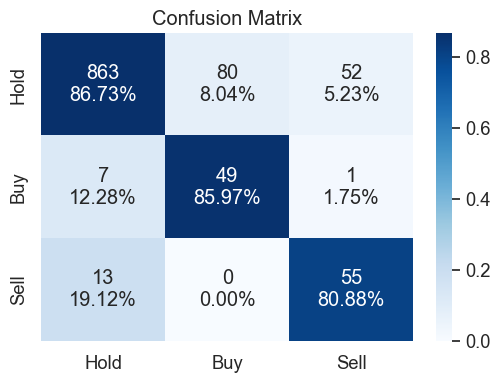

In [70]:
model_name = "CNN_MultiHead"  
print('Model name:',model_name)

label_pred = trained_best_models[model_name].predict(test_data)
print(model_name,' classification Accuracy',utils.f1_score(targets, np.argmax(label_pred,axis=1),average='macro'))

cf_matrix = utils.confusion_matrix(targets,np.argmax(label_pred,axis=1))
 
try:
    utils.plot_confusion_matrix(gesture_list= ['Hold','Buy','Sell'], cf_matrix=cf_matrix)
except:
    print(cf_matrix)

Model name: CNN_MultiHead
35/35 [==============================] - 0s 7ms/step
CNN_MultiHead  classification Accuracy 0.8633928571428572


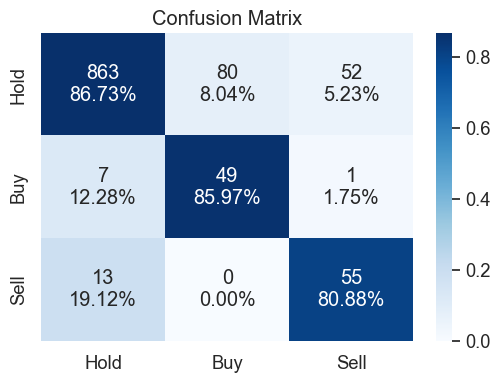

In [71]:
model_name = "CNN_MultiHead"    
print('Model name:',model_name)
x_data= np.apply_along_axis(lambda row: X_data_gen_test.norm_minmax(row, minimum=-1, maximum=1, axis=0), axis=1, arr=X_data_gen_test.features)

label_pred = trained_best_models[model_name].predict(x_data)
print(model_name,' classification Accuracy',
                utils.f1_score(np.argmax(X_data_gen_test.y_classification,axis=1),
                np.argmax(label_pred,axis=1),average="micro"))

cf_matrix = utils.confusion_matrix(np.argmax(X_data_gen_test.y_classification,axis=1),np.argmax(label_pred,axis=1))
 
try:
    utils.plot_confusion_matrix(gesture_list= ['Hold','Buy','Sell'], cf_matrix=cf_matrix)
except:
    print(cf_matrix)

#### Using Machine Learning models to Predicti next recomendations

In [72]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Define ML models and their names
ML_models = {
    'SVM_1': SVC(kernel='rbf',decision_function_shape='ovr'),
    'SVM_2': SVC(kernel='rbf',decision_function_shape='ovo'),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=300),
    'Logistic Regression': LogisticRegression(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'XGBoost RF': xgb.XGBRFClassifier(n_estimators=300)
}

x_data_train= np.vstack(np.apply_along_axis(lambda row: X_data_gen_train.norm_minmax(row, minimum=-1, maximum=1, axis=-1), axis=1, arr=X_data_gen_train.features).T).T
x_data_val= np.vstack(np.apply_along_axis(lambda row: X_data_gen_val.norm_minmax(row, minimum=-1, maximum=1, axis=-1), axis=1, arr=X_data_gen_val.features).T).T
x_data_test= np.vstack(np.apply_along_axis(lambda row: X_data_gen_test.norm_minmax(row, minimum=-1, maximum=1, axis=-1), axis=1, arr=X_data_gen_test.features).T).T


# Iterate over ML models
for name, model in ML_models.items():
    # Train the model
    model.fit(x_data_train, np.argmax(X_data_gen_train.y_classification, axis=1) )

    # Make predictions on datasets
    train_pred = model.predict(x_data_train)
    val_pred = model.predict(x_data_val)
    test_pred = model.predict(x_data_test)

    # Calculate accuracy on datasets
    train_accuracy = accuracy_score(np.argmax(X_data_gen_train.y_classification, axis=1), train_pred)
    val_accuracy = accuracy_score(np.argmax(X_data_gen_val.y_classification, axis=1), val_pred)
    #test_accuracy = accuracy_score(np.argmax(X_data_gen_test.comput_outputs(df[df['Date'].isin(T_test)].iloc[:,1].values), axis=1), test_pred)
    test_accuracy = accuracy_score(np.argmax(X_data_gen_test.y_classification, axis=1), test_pred)

    # Print results
    print('-------------------------------------------------------------')
    print(f'{name} - Train Classification Accuracy: {train_accuracy}')
    print(f'{name} - Validation Classification Accuracy: {val_accuracy}')
    print(f'{name} - Test Classification Accuracy: {test_accuracy}')


-------------------------------------------------------------
SVM_1 - Train Classification Accuracy: 0.9571396345589894
SVM_1 - Validation Classification Accuracy: 0.9300302571860817
SVM_1 - Test Classification Accuracy: 0.9214285714285714
-------------------------------------------------------------
SVM_2 - Train Classification Accuracy: 0.9571396345589894
SVM_2 - Validation Classification Accuracy: 0.9300302571860817
SVM_2 - Test Classification Accuracy: 0.9214285714285714
-------------------------------------------------------------
Decision Tree - Train Classification Accuracy: 1.0
Decision Tree - Validation Classification Accuracy: 0.9459152798789713
Decision Tree - Test Classification Accuracy: 0.95
-------------------------------------------------------------
Random Forest - Train Classification Accuracy: 1.0
Random Forest - Validation Classification Accuracy: 0.9655824508320726
Random Forest - Test Classification Accuracy: 0.9633928571428572


d:\Projetos_python\Time_Series_Forecast\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



-------------------------------------------------------------
Logistic Regression - Train Classification Accuracy: 0.9769907511842996
Logistic Regression - Validation Classification Accuracy: 0.9425113464447806
Logistic Regression - Test Classification Accuracy: 0.9419642857142857
-------------------------------------------------------------
K-Nearest Neighbors - Train Classification Accuracy: 0.935596661403113
K-Nearest Neighbors - Validation Classification Accuracy: 0.8903177004538578
K-Nearest Neighbors - Test Classification Accuracy: 0.8946428571428572
-------------------------------------------------------------
XGBoost RF - Train Classification Accuracy: 0.9904128129934582
XGBoost RF - Validation Classification Accuracy: 0.9667170953101362
XGBoost RF - Test Classification Accuracy: 0.9723214285714286


Model name: XGBoost RF
XGBoost RF  classification Accuracy 0.9129837376044895


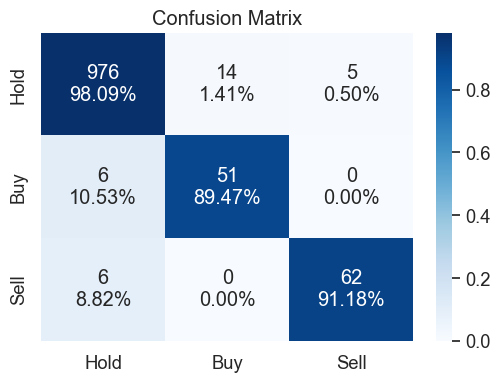

In [73]:
model_name = "XGBoost RF"  
print('Model name:',model_name)

label_pred = ML_models[model_name].predict(np.vstack(test_data.T).T)

print(model_name,' classification Accuracy',utils.f1_score(targets, label_pred, average='macro'))

cf_matrix = utils.confusion_matrix(targets,label_pred)
 
try:
    utils.plot_confusion_matrix(gesture_list= ['Hold','Buy','Sell'], cf_matrix=cf_matrix)
except:
    print(cf_matrix)

### Get new values to future prediction 

In [74]:
dias_antes=1
n_steps=7

print("Temos dados até o dia :",T_test.iloc[-1].date())

print("Estamos Fornecendo dados até o dia :",T_test.iloc[-1].date() -datetime.timedelta(days=dias_antes))

print("O modelo fará previsões até o dia: ",T_test.iloc[-1].date() -datetime.timedelta(days=dias_antes) + datetime.timedelta(days=n_steps))

Temos dados até o dia : 2024-12-15
Estamos Fornecendo dados até o dia : 2024-12-14
O modelo fará previsões até o dia:  2024-12-21


In [75]:
data_inference=df[df['Date'].isin(T_test.iloc[-lookback-3:])].iloc[:,1:]
#data_inference=df[df['Date'].isin(T_test.iloc[:])].iloc[:,1:]
data_inference.shape


(27, 11)

In [76]:
data_inference.shape

(27, 11)

In [77]:
dataGen_inference = FeaturesDataGenerator(data_inference, lookback = lookback, pred_days = pred_days, shuffle= False, batch_size=1, selected_features = features_indicators, data_augmentation=False)

self.pred_days 72
input data shape (3, 24, 22)
output data shape (3, 3)


d:\Projetos_python\Time_Series_Forecast\acoes\Processing\ProcessingPipeline.py:294: RuntimeWarning:

divide by zero encountered in divide

d:\Projetos_python\Time_Series_Forecast\acoes\Processing\ProcessingPipeline.py:294: RuntimeWarning:

invalid value encountered in divide



In [78]:
trade=['Hold','Buy','Sell']

In [79]:
data_inference=df[df['Date'].isin(T_test.iloc[-lookback-pred_days:])].iloc[:,1:]
data_inference=df[df['Date'].isin(T_test.iloc[:-8])].iloc[:,1:]
data_inference['Close'].values.astype(np.float32).shape

(1136,)

In [80]:
x_data_inference=dataGen_inference.comput_features(data_inference, pred_days=0)
x_data_inference.shape

(1112, 24, 22)

In [81]:
x_data_inference=dataGen_inference.comput_features(data_inference, pred_days=0)
x_data= np.apply_along_axis(lambda row: X_data_gen_test.norm_minmax(row, minimum=-1, maximum=1, axis=0), axis=1, arr=x_data_inference)

model_name='CNN_MultiHead'
label_pred = trained_best_models[model_name].predict(x_data)
trade[np.argmax(label_pred[-1])]

35/35 [==============================] - 0s 6ms/step


'Hold'

In [82]:
model_name = "XGBoost RF"  
print('Model name:',model_name)
label_pred = ML_models[model_name].predict(np.vstack(x_data.T).T)
trade[np.argmax(label_pred[-1])]

Model name: XGBoost RF


'Hold'

In [83]:
np.unique(label_pred, return_counts=True)

(array([0, 1, 2], dtype=int64), array([980,  65,  67], dtype=int64))

### Inference in real time data 

In [101]:
from datetime import datetime, timedelta
data_atual = datetime.now()
data_atual_formatada = data_atual.strftime('%Y-%m-%d')
dia_anterior = (data_atual - timedelta(days=11)).strftime('%Y-%m-%d')

interval ='4h'

# Baixar e consolidar dados em um DataFrame
cryptos_df = pd.DataFrame()
for crypto in cryptos:
    data = get_binance_data(crypto, start_time=dia_anterior, interval=interval)
    # Ajusta o nome da coluna removendo "USDT" antes de adicionar ao DF
    #data.columns = [crypto.replace('USDT', '')]
    if cryptos_df.empty:
        cryptos_df = data
    else:
        cryptos_df = pd.concat([cryptos_df, data], axis=1)

if not cryptos_df.empty:
    cryptos_df = cryptos_df.rename(columns={
        'open': 'Open',
        'high': 'High',
        'low': 'Low',
        'close': 'Close',
        'volume': 'Volume',
    })
    # Visualização dos dados
    cryptos_df=cryptos_df.rename_axis('Date')
    print(cryptos_df.shape)
else:
    print("Nenhum dado encontrado para o símbolo e intervalo especificados.")

cryptos_df.reset_index(inplace= True)

(69, 11)


In [102]:
dataGen_inference = FeaturesDataGenerator(data_inference, lookback = lookback, pred_days = pred_days, shuffle= False, batch_size=1, selected_features = features_indicators, data_augmentation=False)
x_data_inference=dataGen_inference.comput_features(cryptos_df, pred_days=0)
x_data_inference.shape

self.pred_days 72


d:\Projetos_python\Time_Series_Forecast\acoes\Processing\ProcessingPipeline.py:294: RuntimeWarning:

invalid value encountered in divide



input data shape (1112, 24, 22)
output data shape (1112, 3)


d:\Projetos_python\Time_Series_Forecast\acoes\Processing\ProcessingPipeline.py:294: RuntimeWarning:

divide by zero encountered in divide



(45, 24, 22)

In [103]:
x_data= np.apply_along_axis(lambda row: X_data_gen_test.norm_minmax(row, minimum=-1, maximum=1, axis=0), axis=1, arr=x_data_inference)
model_name='CNN_MultiHead'
label_pred = trained_best_models[model_name].predict(x_data)
trade[np.argmax(label_pred[-1])]

2/2 [==============================] - 0s 113ms/step


'Hold'

In [104]:
np.argmax(label_pred[:],axis=1)

array([0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0], dtype=int64)

In [105]:
model_name = "XGBoost RF"  
print('Model name:',model_name)
label_pred_ml = ML_models[model_name].predict(np.vstack(x_data.T).T)
trade[label_pred_ml[-1]]

Model name: XGBoost RF


'Hold'

In [106]:
label_pred_ml

array([0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0], dtype=int64)

In [107]:
# Dados de exemplo
try:
    data_idx= -x_data_inference.shape[0]
    input_data = cryptos_df['Close'].iloc[data_idx:].values
    date = cryptos_df['Date'].iloc[data_idx:]
    #labels = labelling_method(close_price_list, 60)

    #labels=[trade[label] for label in label_pred]
    labels=[trade[label] for label in np.argmax(label_pred[:],axis=1)]
    

    labels=labels[data_idx:]
    print(np.unique(labels, return_counts=True))
    portfolio_values = backtest(input_data, labels, initial_capital=100000)

    # Gráfico do desempenho
    import plotly.graph_objects as go

    #fig = go.Figure()

    fig = go.Figure(data=[go.Candlestick(x=cryptos_df['Date'].iloc[data_idx:],
                    open=cryptos_df['Open'].iloc[data_idx:],
                    high=cryptos_df['High'].iloc[data_idx:],
                    low=cryptos_df['Low'].iloc[data_idx:],
                    close=cryptos_df['Close'].iloc[data_idx:],
                    name='Candlestick')])

    # Valor do portfólio
    #fig.add_trace(go.Scatter(
    #    x=X_data_gen_test.InputData['Date'],
    #    y=portfolio_values,
    #    mode='lines',
    #    name='Valor do Portfólio'
    #))

    # Configuração do layout
    fig.update_layout(
        title="Backtest de Estratégia de BUY, SELL, HOLD",
        xaxis_title="Data",
        yaxis_title="Valor",
        showlegend=False,
        width=1700,
        height=600,
        margin=dict(l=50, r=50, t=50, b=50)  # Margem esquerda, direita, superior e inferior
    )


    # Adiciona os marcadores BUY, SELL e HOLD
    for i, label in enumerate(labels):
        if label == "Buy":
            fig.add_trace(go.Scatter(
                x=[date.iloc[i]],
                y=[input_data[i] - 0.01*input_data[i]],
                mode='markers',
                marker=dict(color='green', size=10, symbol='triangle-up'),
                name='BUY'
            ))
        elif label == "Sell":
            fig.add_trace(go.Scatter(
                x=[date.iloc[i]],
                y=[input_data[i] + 0.01*input_data[i]],
                mode='markers',
                marker=dict(color='red', size=10, symbol='triangle-down'),
                name='SELL'
            ))
    fig.update_layout(xaxis_rangeslider_visible=False)
    fig.show()
except Exception as e:\
    print("Erro ao executar o código:", str(e))

(array(['Buy', 'Hold'], dtype='<U4'), array([ 7, 38], dtype=int64))
